# Анализ данных компании Gectaro

Gectaro – облачный сервис для автоматизации управления строительством и ремонтом. Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.

Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.

**Цель исследования**: выделить сегменты клиентов, склонных к оттоку, и сформулировать рекомендации по минимизации оттока в сегментах.

In [1]:
#загрузка библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
from scipy.stats import ttest_ind
import plotly.express as px
from matplotlib import pyplot as plt
import math as mth
from datetime import datetime, timedelta

from scipy.stats import chi2_contingency

!pip -q install phik==0.10.0
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

!pip -q install kaleido
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

## Загрузка данных и изучение общей информации 

In [2]:
#открываем файл activities и смотрим свойства датасета

activities = pd.read_csv('C:/Users/Ксюша/Desktop/Gectaro/activities.csv', index_col= 0)

In [3]:
#открываем файл billing и смотрим свойства датасета

billing = pd.read_csv('C:/Users/Ксюша/Desktop/Gectaro/billing.csv', index_col= 0)

In [4]:
#открываем файл companies и смотрим свойства датасета

companies = pd.read_csv('C:/Users/Ксюша/Desktop/Gectaro/companies.csv', index_col= 0)

In [5]:
#открываем файл people и смотрим свойства датасета

people = pd.read_csv('C:/Users/Ксюша/Desktop/Gectaro/people.csv', index_col= 0)

Посмотрим подробнее файл `activities`

In [6]:
activities.head()

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


In [7]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_id                     6316 non-null   int64  
 1   month                          6316 non-null   object 
 2   company-month-billing          6316 non-null   float64
 3   company-month-stocks           6316 non-null   float64
 4   company-month-backups          6316 non-null   float64
 5   company-month-projects         6316 non-null   float64
 6   company-month-contractors      6316 non-null   float64
 7   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 444.1+ KB


- Пропусков в данных нет.
- Столбец `month` нужно привести к типу date. 
- Названия столбцов следует привести к единому стандарту, то есть заменить на нижнее подчеркивание.

In [8]:
billing.head()

,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


In [9]:
billing = billing. loc [:, ~billing. columns.str.contains('^Unnamed')]

In [10]:
#сбросим старый индекс и удалим его

billing.reset_index(drop= True, inplace= True)

In [11]:
#проверим, не остались ли данные о компаниях с пробными, промо и бесплатными тарифами (1,18,22)

billing['billing_tariff_id'].unique()

array([ 3,  7,  2,  4, 11,  9, 10,  6, 13, 17, 19, 20, 21], dtype=int64)

Данные очищены от компаний, пользующихся пробными, промо и бесплатными тарифами (1, 18, 22).

In [12]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       3480 non-null   int64  
 1   user_id                  3480 non-null   int64  
 2   company_id               3480 non-null   int64  
 3   billing_tariff_id        3480 non-null   int64  
 4   payed_until              3480 non-null   int64  
 5   is_payed                 3480 non-null   bool   
 6   created_at               3480 non-null   int64  
 7   updated_at               3480 non-null   int64  
 8   billing_tariff_price_id  3480 non-null   float64
 9   comment                  745 non-null    object 
 10  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(7), object(1)
memory usage: 275.4+ KB


- В столбцах нет пропусков, кроме столбца с комментариями и pay_date. Скорее всего, этот столбец не обязателен для заполнения.
- Столбцы с датами необходимо привести к типу datetime.

In [13]:
#посмотрим подробнее датасет companies

companies.head()

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,1571316635,1670298314,4.0,True
57,383,Строительство,2.0,1564142565,1676550050,7.0,False
69,495,-,1.0,1570535695,1598281714,2.0,False
75,724,-,1.0,1579514393,1670298294,4.0,True
99,471,-,1.0,1569328017,1670298360,7.0,True


In [14]:
#сбросим старый индекс и удалим его

companies.reset_index(drop= True, inplace= True)

In [15]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       723 non-null    int64  
 1   working_direction        720 non-null    object 
 2   employer_count_interval  723 non-null    float64
 3   created_at               723 non-null    int64  
 4   updated_at               723 non-null    int64  
 5   billing_tariff_id        716 non-null    float64
 6   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 34.7+ KB


- Есть пропуски в столбцах `working_direction` и `billing_tariff_id`
- Необходимо привести столбцы `created_at`, `updated_at` к типу datetime.

In [16]:
#посмотрим подробнее датасет people

people.head()

,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
2,6601,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
6,7025,1,NaN,1,1594120484,1594120484,True,1.594120e+09
7,7165,1255,1734.0,18085,1595438102,1595439391,True,1.633960e+09
10,7130,1470,1703.0,1,1595234824,1595234824,False,NaN
17,7163,1492,1731.0,1,1595429211,1598540644,True,1.620195e+09


In [17]:
#сбросим старый индекс и удалим его

people.reset_index(drop= True, inplace= True)

In [18]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5095 non-null   int64  
 1   company_id  5095 non-null   int64  
 2   user_id     3813 non-null   float64
 3   role_id     5095 non-null   int64  
 4   created_at  5095 non-null   int64  
 5   updated_at  5095 non-null   int64  
 6   is_deleted  5095 non-null   bool   
 7   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(5)
memory usage: 283.7 KB


- Есть пропуски в столбцах `user_id`, `deleted_at`
- Необходимо привести `user_id` к типу integer, а столбцы со временем к типу datetime.

**Выводы**
- Датасеты загружены корректно, сбросили в них старые индексы.
- Столбцы с датами во всех датасетах необходимо привести к типу datetime.
- В `activities` пропусков нет.
- В `billing` наблюдаются пропуски в столбцах `pay_date`, `comment`.
- В `companies` наблюдаются пропуски в столбцах `working_direction` и `billing_tariff_id`.
- В `people` наблюдаются пропуски в `user_id`, `deleted_at`.

## Предобработка данных

###  Приведение названий столбцов к единому виду

В датасете `activities` поменяем дефис - на нижнее подчеркивание.

In [19]:
activities.columns = activities.columns.str.replace("-", "_")

In [20]:
activities.head()

,company_id,month,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


###  Приведение столбцов к верному типу данных

In [21]:
#приведение к типу datetime

people.created_at = pd.to_datetime(people.created_at, unit='s')
people.updated_at = pd.to_datetime(people.updated_at, unit='s')
people.deleted_at = pd.to_datetime(people.deleted_at, unit='s')

In [22]:
companies.created_at = pd.to_datetime(companies.created_at, unit='s')
companies.updated_at = pd.to_datetime(companies.updated_at, unit='s')

In [23]:
billing.payed_until = pd.to_datetime(billing.payed_until, unit='s')
billing.pay_date = pd.to_datetime(billing.pay_date, unit='s')
billing.created_at = pd.to_datetime(billing.created_at, unit='s')
billing.updated_at = pd.to_datetime(billing.updated_at, unit='s')

In [24]:
activities['month'] = pd.to_datetime(activities['month'])

In [25]:
#приведение к целочисленному типу данных

companies['employer_count_interval'] = companies['employer_count_interval'].astype('int')

**Вывод**

- Столбцы с датами приведены к типу datetime.
- Столбцы с целочисленными данными приведены к типу integer.

### Работа с дубликатами

Проверим датасеты на наличие явных дубликатов.

In [26]:
activities.duplicated().sum()

0

In [27]:
people.duplicated().sum()

0

In [28]:
companies.duplicated().sum()

0

In [29]:
billing.duplicated().sum()

0

Полных дубликатов строк в датасетах нет.

In [30]:
#проверим дубликаты в столбце company_id:

activities['company_id'].duplicated().sum()

5600

In [31]:
activities['company_id'].nunique()

716

В датасете `activities` находится только 716 уникальных `company_id`, остальное дубликаты. 

In [32]:
activities[activities['company_id'].duplicated(keep=False)]

,company_id,month,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
6552,7882,2023-12-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0
6553,8495,2024-02-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0
6554,8513,2024-02-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,2.0
6555,8603,2023-11-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,2.0


In [33]:
#проверим дубликаты в столбце company_id:

billing['company_id'].duplicated().sum()

1639

In [34]:
billing['company_id'].nunique()

1841

В датасете billing находится 1841 уникальных company_id, остальное дубликаты.  

In [35]:
companies['id'].duplicated().sum()

0

In [36]:
companies['id'].nunique()

723

В `companies` всего 723 уникальных компании.

In [37]:
people['company_id'].duplicated().sum()

4383

In [38]:
people['company_id'].nunique()

712

В `people` всего 712 уникальных компаний. В целом, здесь дубликаты обусловлены тем, что в каждой компании может быть зарегистрировано несколько сотрудников, поэтому всего 712 компаний, но сотрудников у них может зависеть от выбранного тарифа.

Проверим столбцы, которые должны содержать только несколько значений, на наличие дубликатов.

In [39]:
billing['is_payed'].unique()

array([False,  True])

In [40]:
people['is_deleted'].unique()

array([ True, False])

In [41]:
companies['billing_is_over'].unique()

array([ True, False])

In [42]:
companies['working_direction'].unique()

array(['-', 'Строительство', 'Генеральный подрядчик',
       'Строительная компания', 'Ремонт помещений', 'строительство ',
       'ремонт и отделка', 'СТРОИТЕЛЬСТВО', 'строительство',
       'Строительство домов', 'телемаркетинг', 'ремонт',
       'Ремонт и отделка помещений', '-Малоэтажное строительство',
       'Отделка ', 'Отделка',
       'Проектирование и строительство ресторанов ',
       'строительство  и отделка', 'ремонты', 'Электромонтажные работы',
       'строительная компания (тест)', 'Строительство и ремонт',
       'Демонтажные работы', 'Строительство рыбоводных ферм',
       'Строительно-монтажные работы', 'Строительство каркасных домов',
       'Дизайн интерьеров', 'Ремонтные работы',
       'Малоэтажное строительство ', nan, 'Ремонтно-строительная ',
       'Ремонт под ключ', 'Электромонтаж',
       'Проектирование,  Производство и Строительство',
       'Строительство коттеджей', 'Строительство загородных домов',
       'Малоэтажное строительство', 'Электроэнергетик

В данном столбце много дубликатов. Приводить их к единой категоризации не будем, поскольку нужно разбираться в основных отраслях строительства. Однако для клиента можно дать рекомендацию сделать этот столбец при заполнении с параметрами выбора отраслей, чтобы компании-клиенты могли не сами вписывать наименования, а выбирать из уже прописанных параметров. 

**Вывод**
1. Полные дубликаты строк во всех датасетах отсутствуют.
2. Датасет `activities` имеет 716 уникальных идентификаторов компаний (company_id) и 5600 дублей. Дубли составляют 89% от всего датасета, поэтому удалять их не будем, так как это может существенно исказить результаты исследования.
3. Датасет `billing` имеет 1841 уникальный идентификатор компании (company_id) и 1631 дублей. Дубли составляют 47% от всего датасета, что также слишком много и при удалении может повлиять на результаты. Дубли появились из-за того, что каждый отдельный платеж оформлялся отдельной строкой.
4. Датасет `companies` имеет 723 уникальных идентификаторов компаний и 4383 дублей (86%). Удалять также не будем, поскольку в зависимости от тарифа одна компания могла зарегистрировать разное количество сотрудников в системе.


### Целевая переменная оттока

Предположим, что активное действие - это оплата сервиса. Значит, активными клиентами считаются те, кто на данный момент имеет действующую оплаченную подписку в приложении.В противном случае - компания ушла в отток по непродлению оплаты.

In [43]:
observation_date = datetime(2024, 3, 28)

In [44]:
print(observation_date)

2024-03-28 00:00:00


In [45]:
billing['last_date_pay'] = billing.groupby('user_id')['payed_until'].transform('max')

Посчитаем количество дней между датой продления подписки и датой момента анализа.

Если количество дней будет положительным, то клиент имеет активную подписку, а если отрицательным - то клиент не продлил подписку, а значит ушел в отток. 

In [46]:
billing['recency'] = (billing['last_date_pay'] - observation_date) / np.timedelta64 ( 1 , 'D')

In [47]:
billing.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency
0,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12.0,NaN,NaT,2033-04-10 23:59:59,3300.999988
1,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21,2022-08-28 00:00:00,-578.000000
2,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6.0,NaN,NaT,2023-12-26 00:00:00,-93.000000
3,3065,2352,2035,7,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23.0,NaN,NaT,2022-11-03 00:00:00,-511.000000
4,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00,2021-10-01 00:00:00,-909.000000


Далее создадим функцию, по которой клиент с активной подпиской будет иметь статус "0" и не считаться оттоковым, а с отрицательным значением (неактивной подпиской) будет иметь статус "1", то есть ушел в отток.

In [48]:
# создадим функцию для распределения клиентов по оттоку

def churn_func(recency):
    if recency >= 0:
        return '0'
    if recency < 0:
        return '1' 

In [49]:
# применим функцию и добавим новый столбец

billing['churn'] = billing['recency'].apply(churn_func)

In [50]:
billing.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn
0,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12.0,NaN,NaT,2033-04-10 23:59:59,3300.999988,0
1,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21,2022-08-28 00:00:00,-578.000000,1
2,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6.0,NaN,NaT,2023-12-26 00:00:00,-93.000000,1
3,3065,2352,2035,7,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23.0,NaN,NaT,2022-11-03 00:00:00,-511.000000,1
4,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00,2021-10-01 00:00:00,-909.000000,1


In [51]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       3480 non-null   int64         
 1   user_id                  3480 non-null   int64         
 2   company_id               3480 non-null   int64         
 3   billing_tariff_id        3480 non-null   int64         
 4   payed_until              3480 non-null   datetime64[ns]
 5   is_payed                 3480 non-null   bool          
 6   created_at               3480 non-null   datetime64[ns]
 7   updated_at               3480 non-null   datetime64[ns]
 8   billing_tariff_price_id  3480 non-null   float64       
 9   comment                  745 non-null    object        
 10  pay_date                 1108 non-null   datetime64[ns]
 11  last_date_pay            3480 non-null   datetime64[ns]
 12  recency                  3480 non-

In [52]:
#приведение к целочисленному типу данных

billing['churn'] = billing['churn'].astype('int')

Целевая переменная по оттоку создана.

Далее с учетом распределения клиентов на оттоковых и неоттоковых рассмотрим пропуски в данных.

### Работа с пропусками

In [53]:
#посмотрим количество пропусков в каждом столбце activities

activities.isna().sum()

company_id                       0
month                            0
company_month_billing            0
company_month_stocks             0
company_month_backups            0
company_month_projects           0
company_month_contractors        0
company_month_resource_orders    0
dtype: int64

Пропусков в данных `activities` нет.

In [54]:
#посмотрим количество пропусков в каждом столбце billing

billing.isna().sum()

id                            0
user_id                       0
company_id                    0
billing_tariff_id             0
payed_until                   0
is_payed                      0
created_at                    0
updated_at                    0
billing_tariff_price_id       0
comment                    2735
pay_date                   2372
last_date_pay                 0
recency                       0
churn                         0
dtype: int64

Пропуски есть в двух столбцах:
- `comment`. Данный столбец скорее всего заполнялся по желанию и тут вполне могут быть пропуски.
- `pay_date` - столбец с датой платежа за тариф. Оставим пока пропуски как есть, удалять не будем.

Проверим, много ли среди клиентов с пропусками в `pay_date` отточных.

In [55]:
#посмотрим, как пропуски в столбце pay_date распределились в зависимости от оттока

billing[billing['pay_date'].isna()]['churn'].value_counts()

churn
1    1592
0     780
Name: count, dtype: int64

Среди клиентов с отсутствием данных в `pay_date` 1591 человека ушли в отток. Это логично, поскольку у большинства клиентов, не продливших подписку, в данной колонке будет стоять пропуск. Оставим эти данные, поскольку при удалении можем потерять инсайты по оттоку.

In [56]:
#посмотрим количество пропусков в каждом столбце

people.isna().sum()

id               0
company_id       0
user_id       1282
role_id          0
created_at       0
updated_at       0
is_deleted       0
deleted_at    2915
dtype: int64

Пропуски есть в двух столбцах:
- `user_id`
- `deleted_at`

Заполнять их не представляется возможным, оставим как есть.

In [57]:
#посмотрим количество пропусков в каждом столбце

companies.isna().sum()

id                         0
working_direction          3
employer_count_interval    0
created_at                 0
updated_at                 0
billing_tariff_id          7
billing_is_over            0
dtype: int64

Пропуски есть в двух столбцах:
- `working_direction` (3 пропуска). Возможно, данный столбец заполняется по желанию, поэтому возникают пропуски.
- `billing_tariff_id` (7 пропусков). Данные возможно подтянутся из billing, поскольку там в данном столбце пропусков нет.

### Выводы

В рамках предобработки данных было выполнено:
- В названиях колонок в датасете `activities` заменили дефис на нижнее подчеркивание.
- Данные приведены к нужному типу для дальнейшей работы.
- Проанализированы дубликаты в датасетах. Полных дублей в данных нет, но есть дубли по идентификатору компаний (company_id). Поскольку они составляют значительное количество от датасетов от 50% и более, то было принято решение их оставить.
- Проанализированы пропуски в данных. Пропуски есть в `billing`, `companies`, `people`. Часть столбцов имеет пропущенные значения, скорее всего, потому, что они были необязательны для заполнения. Однако есть пропуски, связанные, с оттоком. Например, если клиент уходил в отток, то в `pay_date` были пропуски.
- Создана целевая переменная оттока в зависимости от давности продления подписки. 


## Исследовательский анализ данных

### Создание переменных для RFM анализа

Данных для полноценных показателей F и M не хватает, однако можно попробовать создать приблизительные переменные, которые будут влиять на вероятность оттока клиентами.

Создадим переменную Frequency, то есть частоту платежей за продление подписки.

**Frequency**

In [58]:
frequency = billing.query("is_payed == True").groupby(["company_id"])['is_payed'].count().reset_index()

In [59]:
frequency

,company_id,is_payed
0,1,1
1,5,6
2,21,10
3,30,8
4,108,2
...,...,...
774,9777,1
775,9802,1
776,9815,1
777,9817,1


In [60]:
frequency = frequency.rename(columns={'is_payed': 'frequency'})

In [61]:
billing = billing.merge(frequency[['frequency','company_id']],  how='left', on='company_id')

In [62]:
billing.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn,frequency
0,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12.0,NaN,NaT,2033-04-10 23:59:59,3300.999988,0,2.0
1,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21,2022-08-28 00:00:00,-578.000000,1,2.0
2,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6.0,NaN,NaT,2023-12-26 00:00:00,-93.000000,1,4.0
3,3065,2352,2035,7,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23.0,NaN,NaT,2022-11-03 00:00:00,-511.000000,1,6.0
4,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00,2021-10-01 00:00:00,-909.000000,1,17.0


In [63]:
billing['frequency'].value_counts()

frequency
1.0     1160
2.0      355
3.0      172
7.0       56
6.0       51
4.0       48
14.0      48
8.0       46
17.0      20
10.0      20
5.0       19
9.0       17
15.0      17
Name: count, dtype: int64

Заметим, что есть компании, которые продляли подписку 14 и более раз. Посмотрим гистограмму, чтобы посмотреть распределение значений.

<Axes: >

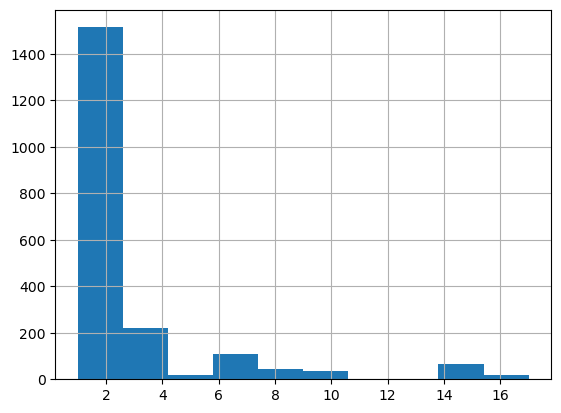

In [64]:
billing['frequency'].hist()

По гистограмме видно, что большинство значений находятся в диапазоне между 1 и 10, тогда как 14 и далее выглядят аномальными значениями.

In [65]:
billing[billing['frequency']>=14]['company_id'].count()

85

Таких компаний, которые продлевали более 14 раз, 85 штук.

In [66]:
billing[billing['frequency']>=14]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn,frequency
4,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9.0,NaN,2020-12-29 00:00:00,2021-10-01 00:00:00,-909.000000,1,17.0
8,3123,531,483,4,2022-01-11 23:59:59,False,2021-01-11 05:14:11,2021-01-11 05:14:11,16.0,NaN,NaT,2022-01-11 23:59:59,-806.000012,1,15.0
11,3107,1134,981,7,2021-02-11 00:00:00,True,2020-12-30 08:38:35,2021-02-10 06:46:28,20.0,"попросил продлить на 1 день, оплатит",2020-12-30 00:00:00,2023-09-16 00:00:00,-194.000000,1,14.0
17,3124,531,483,4,2021-02-11 00:00:00,True,2021-01-11 05:14:25,2021-01-11 05:15:30,13.0,NaN,2021-01-11 05:15:30,2022-01-11 23:59:59,-806.000012,1,15.0
98,3277,1074,926,3,2021-03-02 00:00:00,True,2021-01-25 07:47:02,2021-01-26 15:38:36,9.0,NaN,2021-01-30 00:00:00,2021-10-01 00:00:00,-909.000000,1,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,4434,1134,981,7,2021-09-12 00:00:00,True,2021-06-11 07:55:55,2021-06-11 07:57:40,21.0,NaN,2021-06-11 07:57:40,2023-09-16 00:00:00,-194.000000,1,14.0
1271,5547,1134,981,7,2022-09-21 00:00:00,True,2021-09-21 06:07:46,2021-09-21 07:59:30,23.0,NaN,2021-09-21 07:59:30,2023-09-16 00:00:00,-194.000000,1,14.0
1302,5645,711,628,7,2022-09-29 00:00:00,False,2021-09-29 12:42:14,2021-09-29 12:42:17,23.0,NaN,NaT,2024-04-09 00:00:00,12.000000,0,14.0
2591,9356,1134,981,7,2023-09-16 00:00:00,False,2022-09-16 10:30:32,2022-09-16 10:30:33,23.0,NaN,NaT,2023-09-16 00:00:00,-194.000000,1,14.0


Большинство компаний оплатили сервис 1-4 раза, но также есть компании с оплатой сервиса более 14 раз, что, скорее всего, аномальные значения. Большинство компаний, которые оплачивали 14 раз, находятся в оттоке.

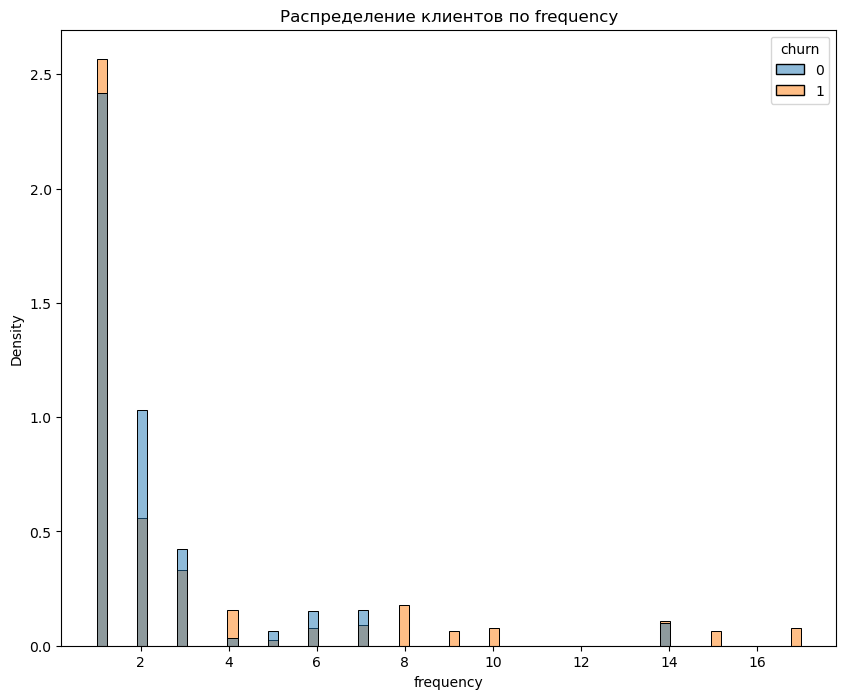

In [67]:
for column in ['frequency']:
    plt.figure(figsize=(10,8))
    sns.histplot(data=billing, x=column, bins=70, hue="churn", stat="density", common_norm=False)
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

Явной зависимости между оттоком и частотой продления подписок нет. Те компании, кто продлевали подписку более 14 раз ушли в отток.

**Monetary**

Попробуем также создать переменную monetary (вложения), то есть сколько компании тратили. Поскольку точных данных у нас нет, то возьмем данные о тарифах.

In [68]:
billing['billing_tariff_id'].value_counts()

billing_tariff_id
2     1539
7     1154
9      269
4      242
3       91
10      88
17      34
6       17
13      14
11      13
20      10
19       8
21       1
Name: count, dtype: int64

In [69]:
billing[billing['billing_tariff_id']==17]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn,frequency
2710,9862,9179,6939,17,2023-12-21,True,2022-12-21 11:57:03,2022-12-21 11:57:49,5.0,NaN,2022-12-21 11:57:49,2025-04-24 00:00:00,392.000000,0,2.0
2713,9864,7083,5492,17,2023-12-21,True,2022-12-21 12:02:49,2022-12-21 12:03:28,5.0,NaN,2022-12-21 12:03:28,2024-06-26 00:00:00,90.000000,0,2.0
2724,9867,9154,6922,17,2023-09-26,True,2022-12-21 13:01:59,2023-09-25 09:19:32,5.0,NaN,2022-12-21 00:00:00,2024-12-01 00:00:00,248.000000,0,2.0
2725,9863,9333,7028,17,2024-12-21,True,2022-12-21 12:00:27,2023-12-20 06:59:05,5.0,NaN,2022-12-21 00:00:00,2024-12-22 00:00:00,269.000000,0,2.0
2726,9870,9159,6927,17,2024-12-21,True,2022-12-21 14:56:50,2023-12-21 06:22:52,5.0,NaN,2022-12-21 00:00:00,2024-12-21 00:00:00,268.000000,0,2.0
2756,9984,5647,4479,17,2023-01-20,True,2023-01-13 09:48:30,2023-01-13 09:50:33,5.0,Активация теста сводного графика 7 дней,2023-01-13 00:00:00,2023-11-21 00:00:00,-128.000000,1,2.0
2821,10241,3568,3003,17,2023-03-17,True,2023-02-16 13:06:15,2023-03-17 10:32:37,2.0,NaN,2023-02-16 00:00:00,2024-03-02 00:00:00,-26.000000,1,3.0
2879,10519,6008,4734,17,2024-09-24,True,2023-03-24 06:50:11,2023-03-24 07:01:56,25.0,NaN,2023-03-24 07:01:56,2024-09-24 00:00:00,180.000000,0,1.0
2883,10504,10045,7494,17,2024-03-11,True,2023-03-22 08:07:48,2024-03-11 14:06:59,25.0,NaN,2023-03-22 00:00:00,2024-03-11 00:00:00,-17.000000,1,2.0
2958,10965,10388,7745,17,2023-06-18,True,2023-05-18 10:01:00,2023-05-18 10:02:28,2.0,NaN,2023-05-18 10:02:28,2025-04-29 00:00:00,397.000000,0,7.0


Чтобы не разбираться, какая цифра какому тарифу принадлежит, категоризируем данные и поделим на 5 тарифов:
- Start (Стартовый)
- Base (Базовый)
- Business (Бизнес)
- Profi (Профи)
- Archive (Архивный).

In [70]:
#создаем функцию

def tariff_category(tariff):
    if tariff in (4,7,8,11,19):
        return 'Start'
    if tariff in(2,17):
        return 'Base'
    if tariff in (9,20):
        return 'Business'
    if tariff in (3,10,13,21):
        return 'Profi' 
    if tariff == 6:
        return 'Archive'

In [71]:
# применим функцию и добавим новый столбец

billing['tariff'] = billing['billing_tariff_id'].apply(tariff_category)

In [72]:
billing['tariff'].value_counts()

tariff
Base        1573
Start       1417
Business     279
Profi        194
Archive       17
Name: count, dtype: int64

Посмотрим, как распределены компании по уровням оттока в зависимости от тарифа.

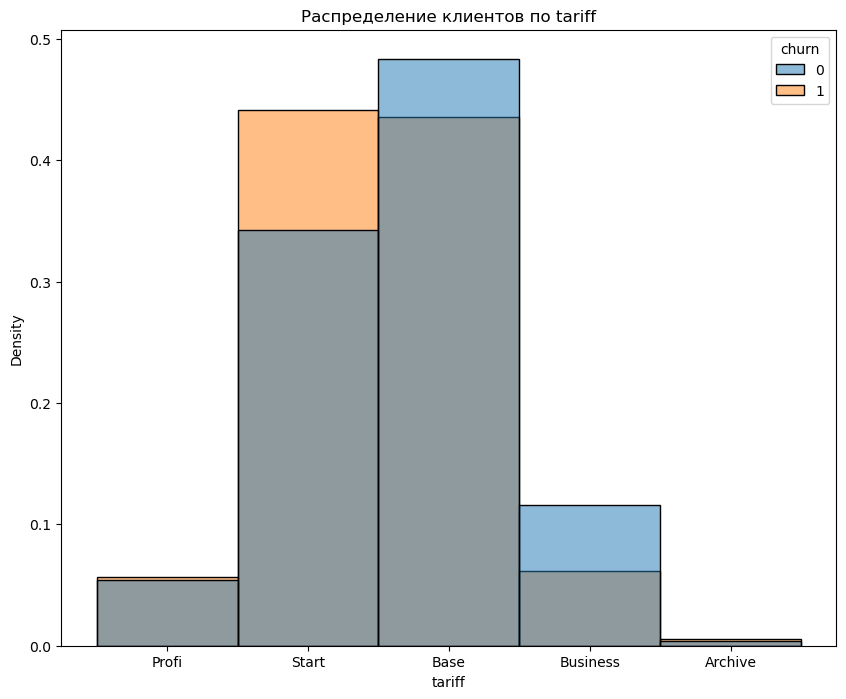

In [73]:
for column in ['tariff']:
    plt.figure(figsize=(10,8))
    sns.histplot(data=billing, x=column, bins=70, hue="churn", stat="density", common_norm=False)
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

Заметно, что уровень оттока превышает в тарифах "Профи" и больше всего в тарифе "Старт".

**Выводы**

- Создали переменные Frequency и Monetary, которые возможно будут оказывать влияние на отток.
- Явной зависимости между оттоком и частотой продления подписок нет.
- Уровень оттока значительно выше в тарифе "Стартовый".

### Работа с аномальными значениями

С учетом новых переменных посмотрим, есть ли аномальные значения в датасетах.

**Activities**

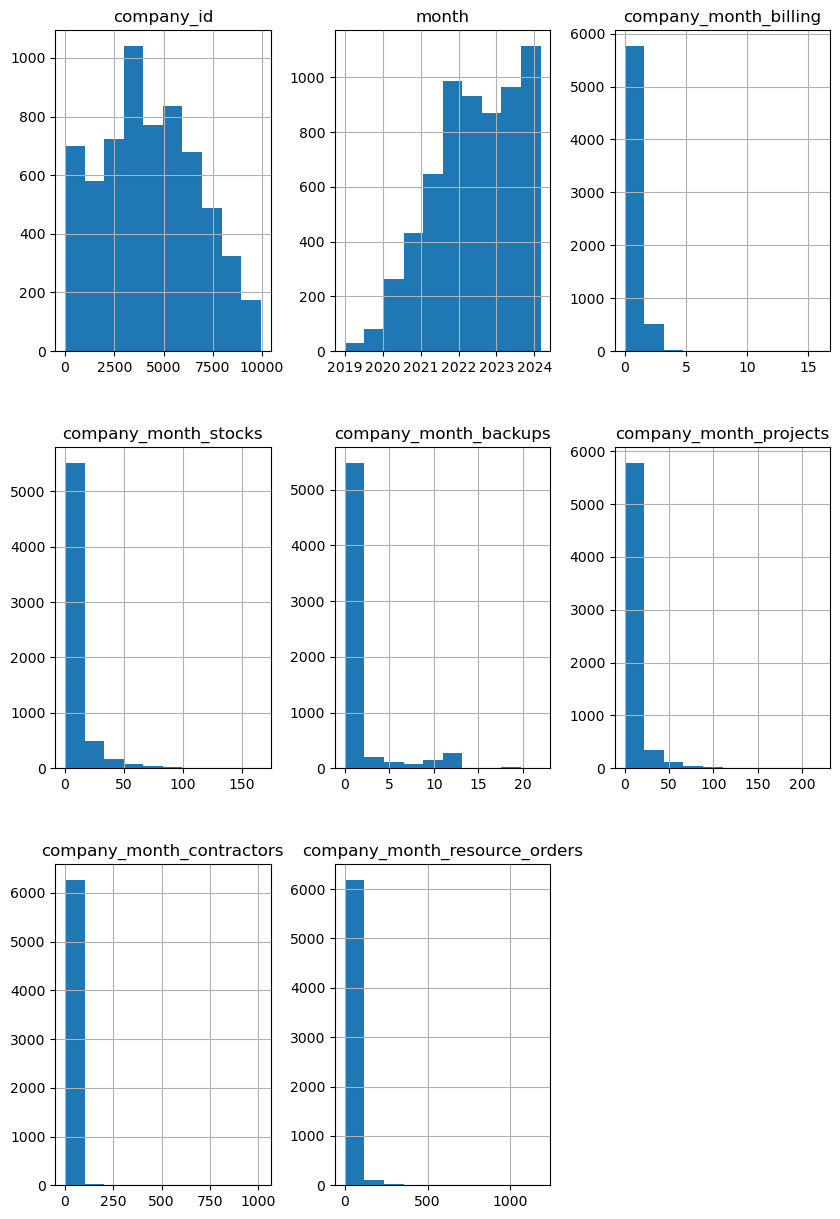

In [74]:
activities.hist(figsize=(10, 15));

In [75]:
#посмотрим описательную статистику датафрейма

pd.set_option("display.float_format", "{:.2f}".format)
activities.describe()

,company_id,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders
count,6316.00,6316.00,6316.00,6316.00,6316.00,6316.00,6316.00
mean,4280.34,0.38,7.41,1.18,7.26,7.91,10.35
std,2413.01,0.80,13.11,3.14,13.90,27.97,40.57
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2459.00,0.00,1.00,0.00,1.00,0.00,0.00
50%,4112.00,0.00,3.00,0.00,2.00,2.00,0.00
75%,6080.00,1.00,8.00,0.00,7.00,7.00,4.00
max,9931.00,16.00,166.00,22.00,221.00,1014.00,1182.00


- Среднее количество счетов = 1, максимальное количество счетов доходит до 16.
- Максимальное количество складов за месяц доходит до 166, минимальное - 0. В среднем, компании используют 7-8 складов в месяц.
- Количество бэкапов компании от 0 до 22 в месяц. 
- В среднем за месяц у компаний по 7 проектов, максимальное количество проектов - 221.
- Максимальное количество контрагентов за месяц - 1014, в среднем - 8.
- Максимальное количество заказов на материалы за месяц - 1182, в среднем - 11.

Абсурдных значений в датасете не наблюдается.

**Billing**

In [76]:
#посмотрим описательную статистику датафрейма

pd.set_option("display.float_format", "{:.2f}".format)
billing.describe()

,id,user_id,company_id,billing_tariff_id,payed_until,created_at,updated_at,billing_tariff_price_id,pay_date,last_date_pay,recency,churn,frequency
count,3480.00,3480.00,3480.00,3480.00,3480,3480,3480,3480.00,1108,3480,3480.00,3480.00,2029.00
mean,6864.15,5478.77,4285.72,4.91,2023-02-27 16:36:26.623276032,2022-01-23 04:27:24.612931072,2022-02-12 11:18:13.425574656,21.02,2022-05-04 07:52:33.683212800,2023-09-17 14:50:27.540804608,-192.38,0.66,2.64
min,376.00,1.00,1.00,2.00,2019-09-11 23:59:59,2019-07-23 09:32:39,2019-07-23 09:32:39,1.00,2020-12-16 12:43:27,2019-10-23 23:59:59,-1617.00,0.00,1.00
25%,4438.50,2952.25,2546.00,2.00,2022-04-06 00:00:00,2021-06-11 13:12:27,2021-06-23 20:30:38.249999872,10.00,2021-06-30 00:00:00,2022-11-23 18:00:00,-490.25,0.00,1.00
50%,6814.50,5535.50,4396.00,4.00,2023-06-04 12:00:00,2022-01-15 23:21:57.500000,2022-01-25 12:46:59.500000,23.00,2022-03-30 00:00:00,2023-10-11 00:00:00,-169.00,1.00,1.00
75%,9234.00,7556.50,5833.00,7.00,2024-01-30 00:00:00,2022-08-29 12:46:51.249999872,2022-10-18 15:14:28.750000128,26.00,2023-02-28 00:00:00,2024-08-19 00:00:00,144.00,1.00,3.00
max,18932.00,14517.00,10851.00,21.00,2033-04-10 23:59:59,2024-03-13 10:24:06,2024-03-13 10:26:17,66.00,2024-03-15 00:00:00,2033-04-10 23:59:59,3301.00,1.00,17.00
std,3380.40,3265.94,2388.42,3.21,NaN,NaN,NaN,9.95,NaN,NaN,525.18,0.48,3.23


Аномальных значения наблюдаются в стобце с`frequency`.

C:\Users\Ксюша\AppData\Local\Temp\ipykernel_7312\1685145427.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(billing[column], hist=True,  bins=70, color = 'blue',  hist_kws={'edgecolor':'black'})


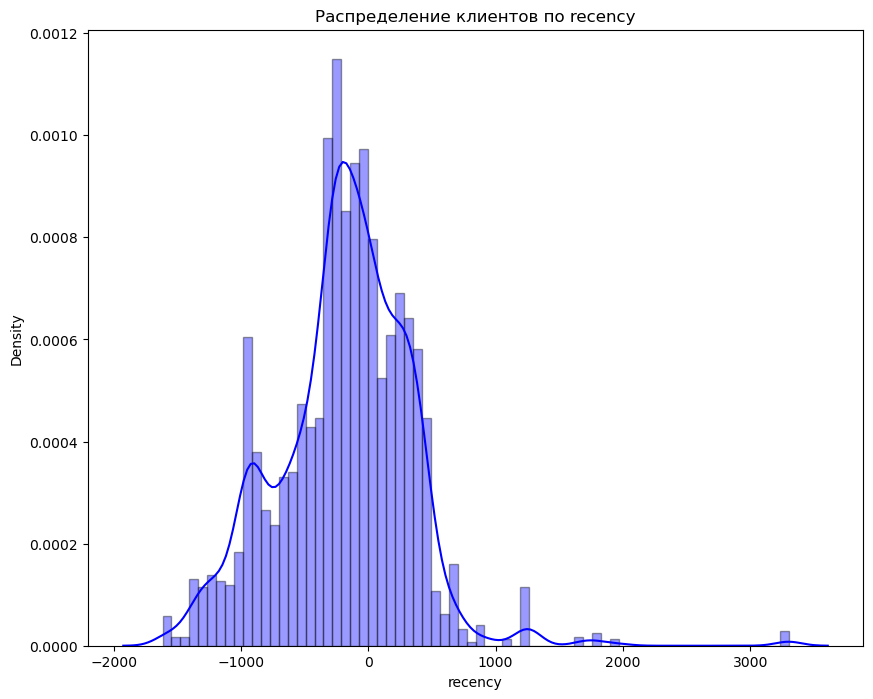

C:\Users\Ксюша\AppData\Local\Temp\ipykernel_7312\1685145427.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(billing[column], hist=True,  bins=70, color = 'blue',  hist_kws={'edgecolor':'black'})


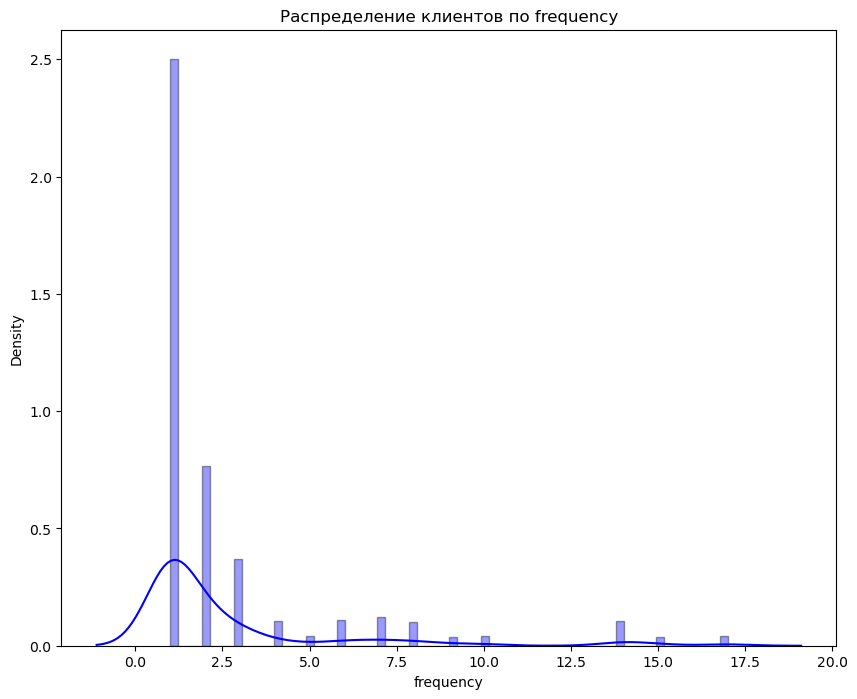

In [77]:
for column in ['recency', 'frequency']:
    plt.figure(figsize=(10,8))
    sns.distplot(billing[column], hist=True,  bins=70, color = 'blue',  hist_kws={'edgecolor':'black'})
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

Frequency, recency имеют нормальное распределение с правосторонней ассиметрией.

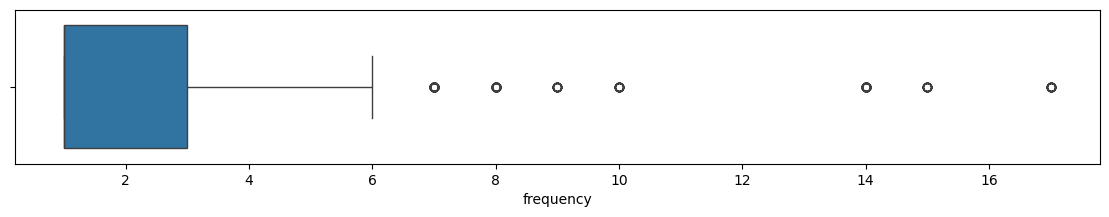

In [78]:
plt.figure(figsize=(14, 2))
sns.boxplot(billing.frequency, orient='h');

Можно избавиться от значений, где продления подписки свыше 14 раз. Таких строк - 85, что составляет 2,4% от всего датасета.

In [79]:
billing = billing[billing['frequency'] < 14]

Далее посмотрим на ящик с усами по Recency.

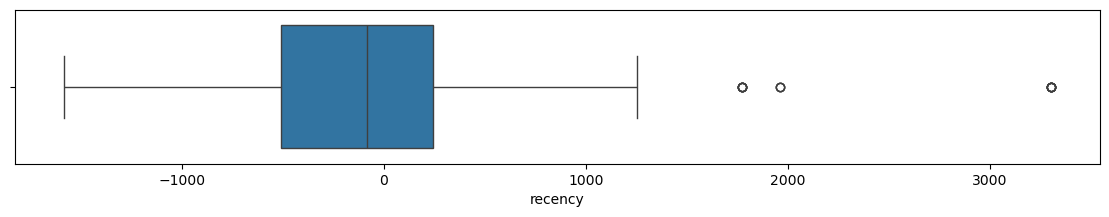

In [80]:
plt.figure(figsize=(14, 2))
sns.boxplot(billing.recency, orient='h');

Есть аномальное значение в виде значения в 3000 дней до истечения подписки. Скорее всего, компания недавно продлила подписку.

In [81]:
billing[billing['recency']>= 3000]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn,frequency,tariff
0,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Profi
55,3045,567,512,2,2026-01-05 23:59:59,False,2020-12-21 14:47:22,2020-12-21 14:47:22,1.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Base
83,3046,567,512,6,2021-06-21 14:55:39,False,2020-12-21 14:55:39,2020-12-21 14:55:39,17.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Archive
101,3047,567,512,7,2033-04-10 23:59:59,False,2020-12-21 15:05:06,2020-12-21 15:05:06,23.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Start
557,4063,567,512,2,2026-12-05 23:59:59,False,2021-05-11 07:32:19,2021-05-11 07:32:19,8.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Base
829,856,567,512,4,2020-04-30 00:00:00,True,2020-01-30 07:23:37,2020-01-30 07:24:15,14.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Start
878,938,567,512,2,2023-01-26 00:00:00,True,2020-03-04 12:49:11,2023-01-26 15:18:59,1.00,NaN,NaT,2033-04-10 23:59:59,3301.00,0,2.00,Base


Всего 1 компания имеет такую подписку, поэтому можно ее удалить из датасета, чтобы сократить количество выбросов.

In [82]:
billing = billing[billing['recency'] < 3000]

**Companies**

In [83]:
#посмотрим описательную статистику датафрейма

pd.set_option("display.float_format", "{:.2f}".format)
companies.describe()

,id,employer_count_interval,created_at,updated_at,billing_tariff_id
count,723.00,723.00,723,723,716.00
mean,4618.42,1.52,2021-11-05 22:12:26.153526784,2023-04-06 03:31:12.546334720,5.02
min,1.00,1.00,2019-01-23 14:00:51,2020-07-06 14:49:27,2.00
25%,2562.50,1.00,2020-12-27 21:42:21.500000,2022-12-06 03:45:22.500000,2.00
50%,4430.00,1.00,2021-10-14 08:13:28,2022-12-19 10:05:07,4.00
75%,6679.00,2.00,2022-09-12 10:24:13.500000,2023-09-22 23:59:20,7.00
max,9931.00,8.00,2024-02-07 12:56:09,2024-03-13 10:44:24,21.00
std,2612.61,1.03,NaN,NaN,3.45


Аномальных количественных значений нет.

**People**

In [84]:
#посмотрим описательную статистику датафрейма

pd.set_option("display.float_format", "{:.2f}".format)
people.describe()

,id,company_id,user_id,role_id,created_at,updated_at,deleted_at
count,5095.00,5095.00,3813.00,5095.00,5095,5095,2180
mean,14164.08,4688.92,7035.18,46651.67,2022-03-30 00:32:14.156820224,2022-04-10 19:44:11.085966592,2022-06-20 12:35:09.823394560
min,2038.00,1.00,1.00,1.00,2019-01-23 14:00:51,2019-01-25 21:12:09,2019-01-25 21:13:48
25%,10285.50,2833.00,4154.00,1.00,2021-06-07 16:32:30.500000,2021-06-16 06:20:55,2021-09-09 03:20:17.249999872
50%,14436.00,4610.00,7222.00,43711.00,2022-04-10 08:46:47,2022-04-19 08:20:16,2022-08-03 06:08:53.500000
75%,18003.50,6805.00,9982.00,84975.00,2023-03-15 10:45:38.500000,2023-03-29 09:32:36.500000,2023-05-18 13:24:28.500000
max,21904.00,9538.00,12992.00,135350.00,2023-12-13 14:41:23,2023-12-13 14:42:02,2023-12-13 14:37:32
std,4531.50,2469.63,3478.28,42650.54,NaN,NaN,NaN


**Выводы**

- Были удалены аномальные значения в количестве продлений подписок (2,4% данных).
- Была удалена компания, которая недавно продлила подписку и имеет 3000 дней до следующей оплаты.
- Других аномальных данных в датасетах не наблюдается.

### Объединение датасетов

Соединим датасеты, чтобы проанализировать группы клиентов с высоким уровнем оттока,а также просмотреть общий портрет клиентов приложения.

In [85]:
#присоединим данные из billing к датасету activities

df = activities.merge(billing[['recency', 'churn', 'frequency', 'tariff', 'company_id']],  how='left', on='company_id')

In [86]:
df.head()

,company_id,month,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders,recency,churn,frequency,tariff
0,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi
1,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi
2,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi
3,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi
4,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi


Далее присоединим к df информацию из датасета `companies`. Для этого необходимо переименовать столбец с идентификаторами компаний.

In [87]:
companies.rename(columns = {'id':'company_id'}, inplace = True)

In [88]:
companies.head()

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,-,1,2019-10-17 12:50:35,2022-12-06 03:45:14,4.00,True
1,383,Строительство,2,2019-07-26 12:02:45,2023-02-16 12:20:50,7.00,False
2,495,-,1,2019-10-08 11:54:55,2020-08-24 15:08:34,2.00,False
3,724,-,1,2020-01-20 09:59:53,2022-12-06 03:44:54,4.00,True
4,471,-,1,2019-09-24 12:26:57,2022-12-06 03:46:00,7.00,True


In [89]:
#присоединим данные из companies

df = df.merge(companies[['working_direction', 'employer_count_interval', 'created_at', 'updated_at', 'billing_is_over', 'company_id']],  how='left', on='company_id')

In [90]:
df.head()

,company_id,month,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders,recency,churn,frequency,tariff,working_direction,employer_count_interval,created_at,updated_at,billing_is_over
0,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi,строительство,3,2019-01-23 14:00:51,2022-12-06 03:45:31,True
1,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi,строительство,3,2019-01-23 14:00:51,2022-12-06 03:45:31,True
2,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi,строительство,3,2019-01-23 14:00:51,2022-12-06 03:45:31,True
3,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi,строительство,3,2019-01-23 14:00:51,2022-12-06 03:45:31,True
4,1,2019-09-01 00:00:00+00:00,1.00,0.00,0.00,7.00,0.00,0.00,-976.00,1.00,1.00,Profi,строительство,3,2019-01-23 14:00:51,2022-12-06 03:45:31,True


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   company_id                     18979 non-null  int64              
 1   month                          18979 non-null  datetime64[ns, UTC]
 2   company_month_billing          18979 non-null  float64            
 3   company_month_stocks           18979 non-null  float64            
 4   company_month_backups          18979 non-null  float64            
 5   company_month_projects         18979 non-null  float64            
 6   company_month_contractors      18979 non-null  float64            
 7   company_month_resource_orders  18979 non-null  float64            
 8   recency                        18859 non-null  float64            
 9   churn                          18859 non-null  float64            
 10  frequency             

In [92]:
df['company_id'].nunique()

716

In [93]:
#посмотрим описательную статистику датафрейма

pd.set_option("display.float_format", "{:.2f}".format)
df.describe()

,company_id,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders,recency,churn,frequency,employer_count_interval,created_at,updated_at
count,18979.00,18979.00,18979.00,18979.00,18979.00,18979.00,18979.00,18859.00,18859.00,18859.00,18979.00,18979,18979
mean,3406.28,0.47,9.27,1.60,9.13,8.00,11.19,-123.88,0.54,3.10,1.76,2021-04-09 21:30:20.553611776,2023-04-09 21:16:28.037462528
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-1584.00,0.00,1.00,1.00,2019-01-23 14:00:51,2020-08-24 15:08:34
25%,1339.00,0.00,1.00,0.00,1.00,0.00,0.00,-441.00,0.00,1.00,1.00,2020-06-24 14:08:15,2022-12-06 03:45:14
50%,3263.00,0.00,3.00,0.00,3.00,2.00,0.00,-48.00,1.00,2.00,1.00,2021-05-06 08:55:48,2023-03-07 22:00:01
75%,5056.00,1.00,10.00,0.00,10.00,7.00,3.00,241.00,1.00,4.00,2.00,2022-01-14 10:52:42,2023-10-26 12:16:24
max,9931.00,16.00,166.00,22.00,221.00,1014.00,1182.00,1772.00,1.00,10.00,8.00,2024-02-07 12:56:09,2024-03-13 10:44:24
std,2338.11,1.20,15.56,3.55,16.88,25.41,44.98,484.71,0.50,2.62,1.24,NaN,NaN


**Выводы**

Для составления полной картины по оттоку мы объединили данные из датасетов activities, billing и companies в один. 

### Анализ категориальных признаков

In [94]:
billing['is_payed'].value_counts()

is_payed
True     1054
False     883
Name: count, dtype: int64

In [95]:
companies['billing_is_over'].value_counts()

billing_is_over
True     481
False    242
Name: count, dtype: int64

In [96]:
people['is_deleted'].value_counts()

is_deleted
False    2912
True     2183
Name: count, dtype: int64

В основном, в столбцах с булевыми значениями данные распределены равномерно.

Посмотрим, как распределены категориальные значения в столбцах с тарифными планами `tariff` в billing и количества сотрудников `employer_count_interval` в companies.

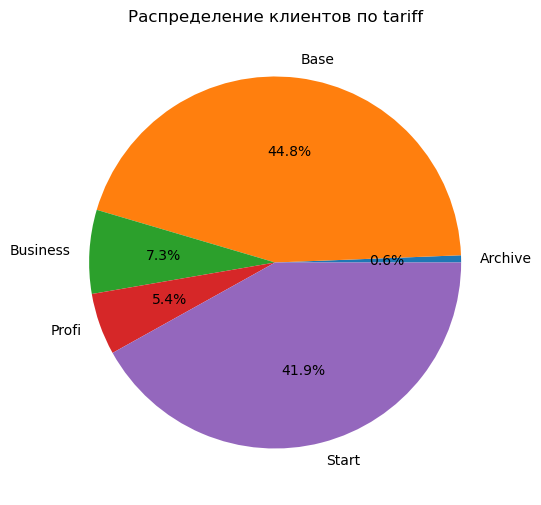

In [97]:
for column in ['tariff']:
    data = billing.groupby(column).agg({'company_id': 'count'})
    fig1, ax1 = plt.subplots(figsize=(6,8))
    ax1.pie(data['company_id'], labels=data.index, autopct='%1.1f%%')
    ax1.set_title(f'Распределение клиентов по {column}')
    plt.show()

Клиенты с архивным тарифом составляют всего 0,6% от общей выборки. Посмотрим детальнее, что это за клиенты и сколько их.

In [98]:
billing[billing['tariff']== 'Archive']['company_id'].count()

12

Всего 12 компаний имеют такой тариф.

In [99]:
billing[billing['tariff']== 'Archive']

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn,frequency,tariff
113,4481,1683,1451,6,2022-06-18,True,2021-06-16 16:30:49,2021-06-22 09:01:10,18.00,NaN,2021-06-16 00:00:00,2022-06-18 00:00:00,-649.00,1,1.00,Archive
188,4576,4458,3640,6,2022-07-10,True,2021-06-25 19:15:11,2021-06-29 10:10:11,18.00,NaN,2021-06-25 00:00:00,2024-07-06 00:00:00,100.00,0,2.00,Archive
665,4231,3903,3244,6,2023-07-05,True,2021-05-24 12:39:30,2021-05-31 13:27:00,19.00,NaN,2021-06-05 00:00:00,2023-07-05 00:00:00,-267.00,1,3.00,Archive
688,4313,2834,2459,6,2023-07-02,True,2021-06-01 06:53:28,2021-06-01 07:10:06,18.00,24 мес + 30дней,2021-06-01 00:00:00,2023-07-02 00:00:00,-270.00,1,1.00,Archive
875,1014,461,419,6,2020-10-01,True,2020-03-30 14:24:24,2020-03-31 09:46:11,17.00,"оплатил 31,03",NaT,2020-10-01 00:00:00,-1274.00,1,1.00,Archive
884,1040,977,845,6,2021-04-09,True,2020-04-07 06:22:22,2020-04-07 06:22:39,18.00,NaN,NaT,2022-11-11 00:00:00,-503.00,1,2.00,Archive
914,1227,116,108,6,2020-10-28,True,2020-04-27 11:57:10,2020-04-27 11:57:40,17.00,NaN,NaT,2022-12-05 00:00:00,-479.00,1,2.00,Archive
1472,6131,977,845,6,2022-11-11,True,2021-11-11 14:25:37,2021-11-11 14:27:04,18.00,NaN,2021-11-11 14:27:04,2022-11-11 00:00:00,-503.00,1,2.00,Archive
1676,3588,1818,1568,6,2023-01-11,True,2021-03-15 12:12:48,2021-12-28 11:24:02,27.00,"16,03,21 пришла оплата; 02,09,21 - отключение ...",2021-03-16 00:00:00,2023-01-11 00:00:00,-442.00,1,1.00,Archive
2483,8828,4458,3640,6,2024-07-06,True,2022-07-06 15:28:57,2022-07-06 15:41:41,19.00,NaN,2022-07-06 15:41:41,2024-07-06 00:00:00,100.00,0,2.00,Archive


Пока оставим данные, возможно, компании сменили тарифы или данный тариф выгоднее, хотя всего 4 компании не оттоковые при данном тарифе.

In [100]:
companies['employer_count_interval'].value_counts()

employer_count_interval
1    498
2    147
3     46
4     14
5      9
8      4
7      3
6      2
Name: count, dtype: int64

Посмотрим распределение категориальных переменных в объединенном датасете df.

In [101]:
df['tariff'].value_counts()

tariff
Start       8412
Base        7807
Business    1459
Profi       1026
Archive      155
Name: count, dtype: int64

In [102]:
df['employer_count_interval'].value_counts()

employer_count_interval
1    11008
2     4309
3     2570
4      460
8      304
5      212
6       82
7       34
Name: count, dtype: int64

 Распределение похоже на начальные датасеты. Тем не менее, можно 6,7,8 идентификаторы количества сотрудников объединить в одну категорию, поскольку значений в них мало.

In [103]:
df.loc[df['employer_count_interval'] >= 6, 'employer_count_interval'] = 6

In [104]:
df['employer_count_interval'].value_counts()

employer_count_interval
1    11008
2     4309
3     2570
4      460
6      420
5      212
Name: count, dtype: int64

### Общий портрет клиентов Gectaro

Проанализируем и составим общий портрет клиентов приложения Gectaro.

In [105]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
company_id,18979.00,3406.28,1.00,1339.00,3263.00,5056.00,9931.00,2338.11
company_month_billing,18979.00,0.47,0.00,0.00,0.00,1.00,16.00,1.20
company_month_stocks,18979.00,9.27,0.00,1.00,3.00,10.00,166.00,15.56
company_month_backups,18979.00,1.60,0.00,0.00,0.00,0.00,22.00,3.55
company_month_projects,18979.00,9.13,0.00,1.00,3.00,10.00,221.00,16.88
company_month_contractors,18979.00,8.00,0.00,0.00,2.00,7.00,1014.00,25.41
company_month_resource_orders,18979.00,11.19,0.00,0.00,0.00,3.00,1182.00,44.98
recency,18859.00,-123.88,-1584.00,-441.00,-48.00,241.00,1772.00,484.71
churn,18859.00,0.54,0.00,0.00,1.00,1.00,1.00,0.50
frequency,18859.00,3.10,1.00,1.00,2.00,4.00,10.00,2.62


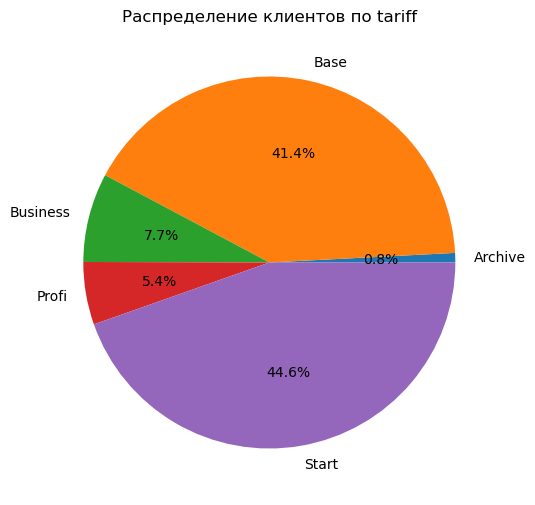

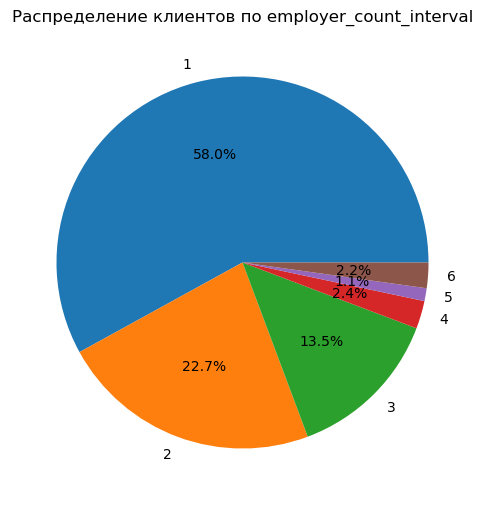

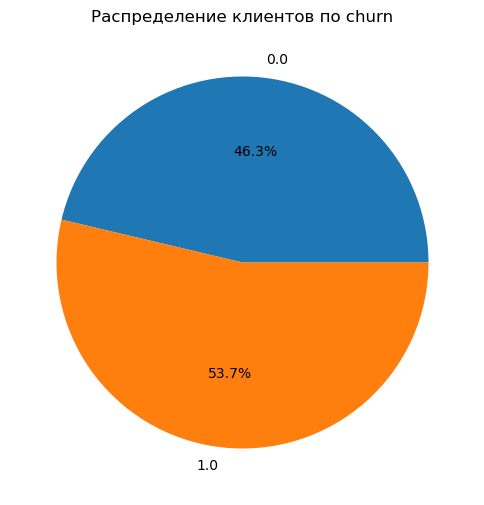

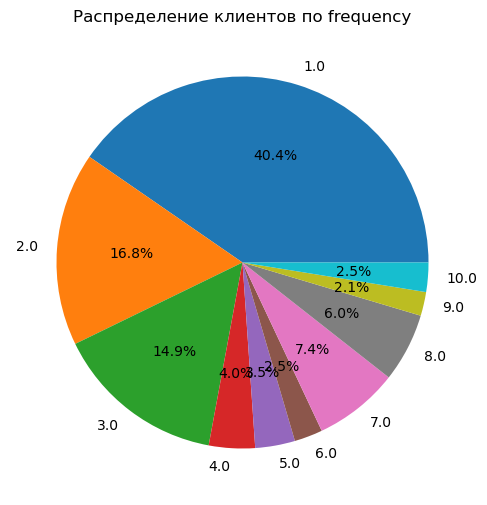

In [106]:
for column in ['tariff', 'employer_count_interval', 'churn', 'frequency']:
    data = df.groupby(column).agg({'company_id': 'count'})
    fig1, ax1 = plt.subplots(figsize=(6,8))
    ax1.pie(data['company_id'], labels=data.index, autopct='%1.1f%%')
    ax1.set_title(f'Распределение клиентов по {column}')
    plt.show()

- Около 86% клиентов пользуются тарифами "Базовый" и "Стартовый".
- 80,7% компаний имею в штате до 10 сотрудников. 58% - имеют до 4 сотрудников в штате. 
- Более половины компаний оплачивали подписку 3 раза.
- Отток в компании составляет примерно 53%.

Детальнее посмотрим на данные в разрезе оттоковых и неоттоковых клиентов, чтобы выявить факторы, которые могли бы оказать влияние.

In [107]:
df.groupby(['churn'])[['company_month_stocks', 'company_month_backups', 'company_month_billing', 'company_month_projects', 'company_month_contractors', 'company_month_resource_orders']].agg(['mean']).T

,churn,0.00,1.00
company_month_stocks,mean,11.01,7.70
company_month_backups,mean,1.76,1.46
company_month_billing,mean,0.31,0.60
company_month_projects,mean,10.85,7.59
company_month_contractors,mean,10.38,5.98
company_month_resource_orders,mean,20.02,3.69


Выявим интересные наблюдения по средним значениям двух выборок:
- Клиенты, ушедшие в отток, использовали меньшее количество складов (8), тогда как лояльные компании используют около 11.
- Клиенты, ушедшие в отток, немного реже делали бэкап, чем компании, не ушедшие в отток.
- У оттоковых компаний в среднем было 6 контрагентов, тогда как у неоттоковых - 10.
- Значительная разница между оттоком и неоттоком наблюдается в количестве заказов на материалы. Компании, ушедшие в отток, заказали около 4 раз, тогда как активные компании заказывали 20 раз.

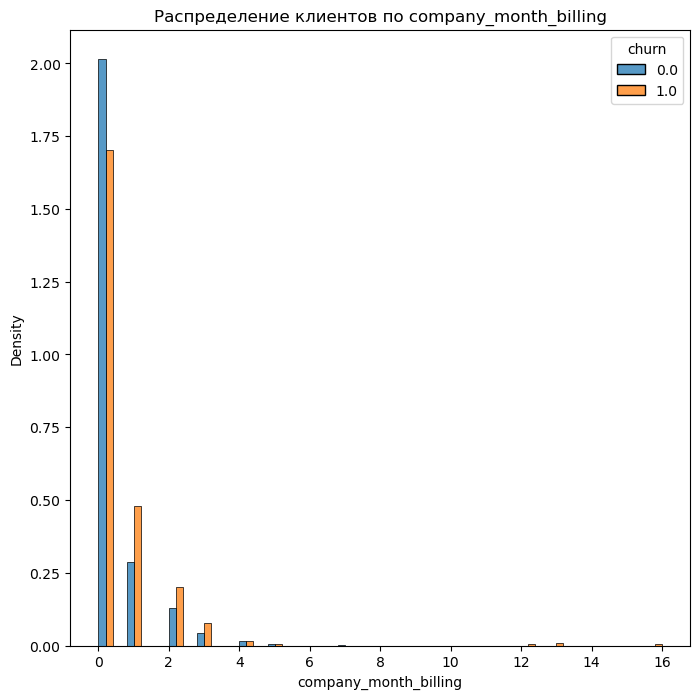

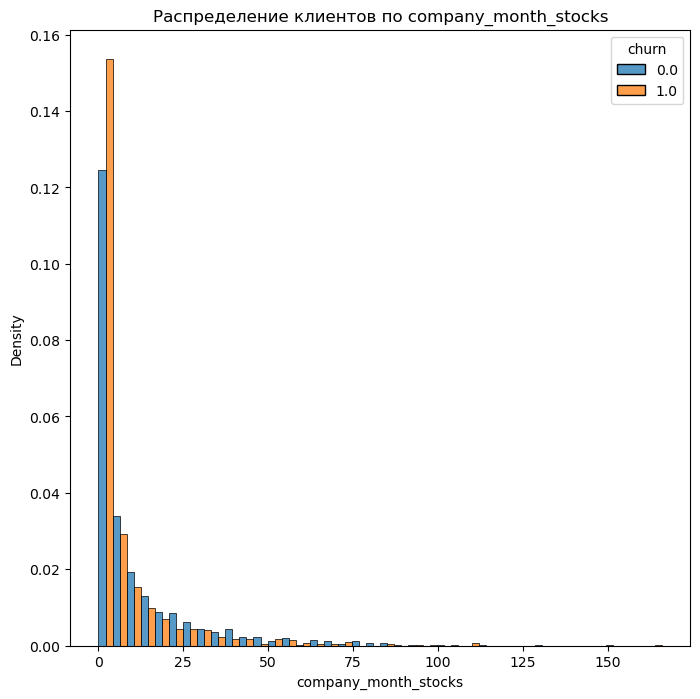

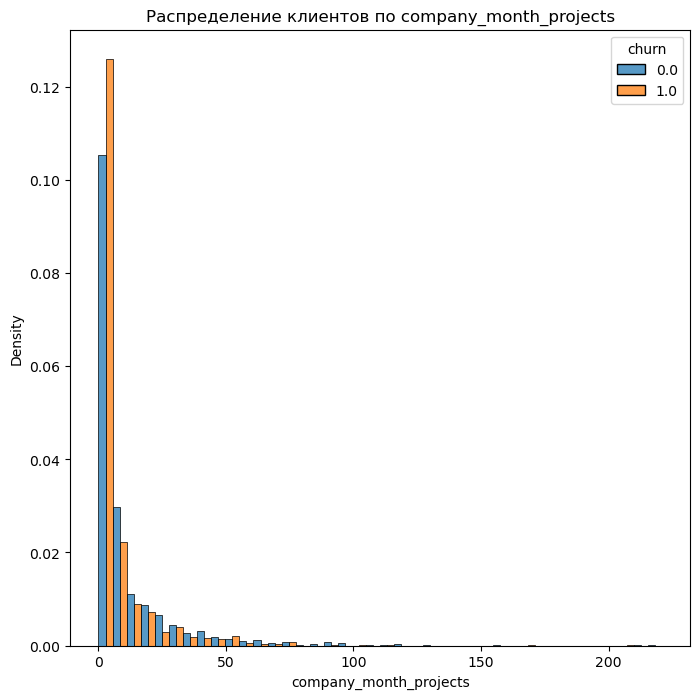

In [108]:
for column in ['company_month_billing','company_month_stocks', 'company_month_projects']:
    plt.figure(figsize=(8,8))
    sns.histplot(data=df, x=column, bins=40, hue="churn", multiple='dodge', color=['navy', 'cornflowerblue'], stat="density", common_norm=False)
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

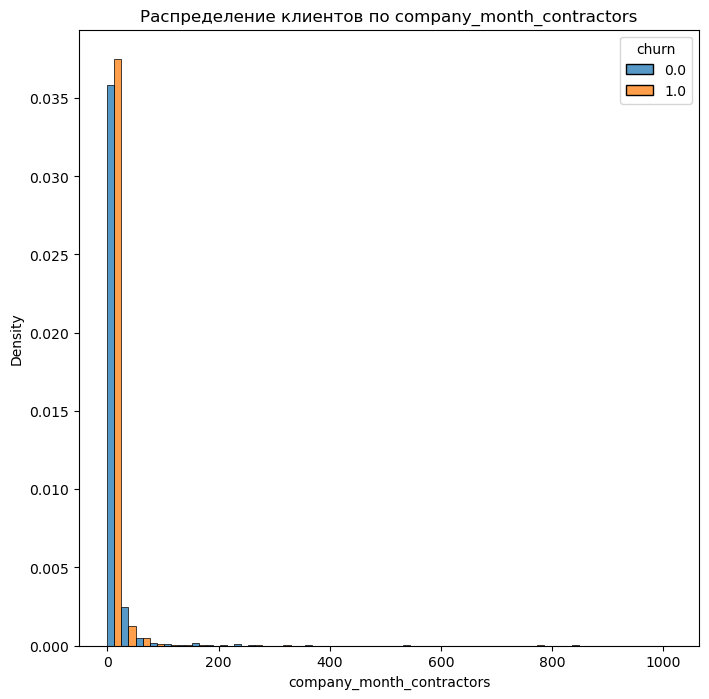

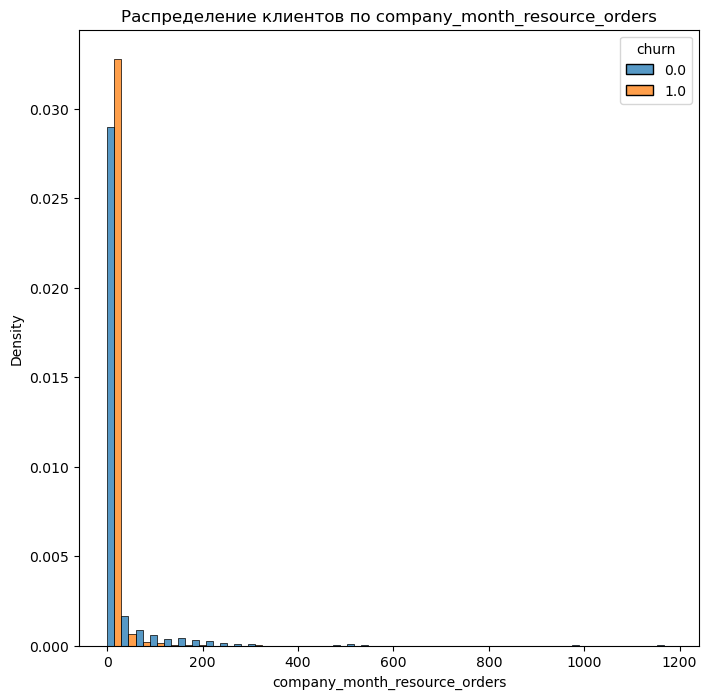

In [109]:
for column in ['company_month_contractors','company_month_resource_orders']:
    plt.figure(figsize=(8,8))
    sns.histplot(data=df, x=column, bins=40, hue="churn", multiple='dodge', color=['navy', 'cornflowerblue'], stat="density", common_norm=False)
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

Выявим интересные наблюдения в распределении количественных данных по уровню оттока:
- Уровень оттока повышается в зависимости от количества выставленных счетов компанией. Чем больше компания выставляла счета, тем больше уровень оттока среди них.
- Уровень оттока снижается в зависимости от количества складов, используемых компанией. Чем больше складов компания использует, тем меньше уровень оттока.
- Уровень оттока снижается в зависимости от увеличения количества контрагентов.
- Уровень оттока снижается по мере увеличения количества заказов на материалы.

### Матрицы корреляций

Отрисуем матрицу корреляций для количественных признаков.

In [110]:
cols_to_keep = ['churn','company_month_contractors','company_month_resource_orders','company_month_billing','company_month_stocks', 'company_month_projects', 'company_month_backups', 'recency', 'frequency']

df_corr = df[cols_to_keep]
df_corr.head()

,churn,company_month_contractors,company_month_resource_orders,company_month_billing,company_month_stocks,company_month_projects,company_month_backups,recency,frequency
0,1.00,0.00,0.00,1.00,0.00,7.00,0.00,-976.00,1.00
1,1.00,0.00,0.00,1.00,0.00,7.00,0.00,-976.00,1.00
2,1.00,0.00,0.00,1.00,0.00,7.00,0.00,-976.00,1.00
3,1.00,0.00,0.00,1.00,0.00,7.00,0.00,-976.00,1.00
4,1.00,0.00,0.00,1.00,0.00,7.00,0.00,-976.00,1.00


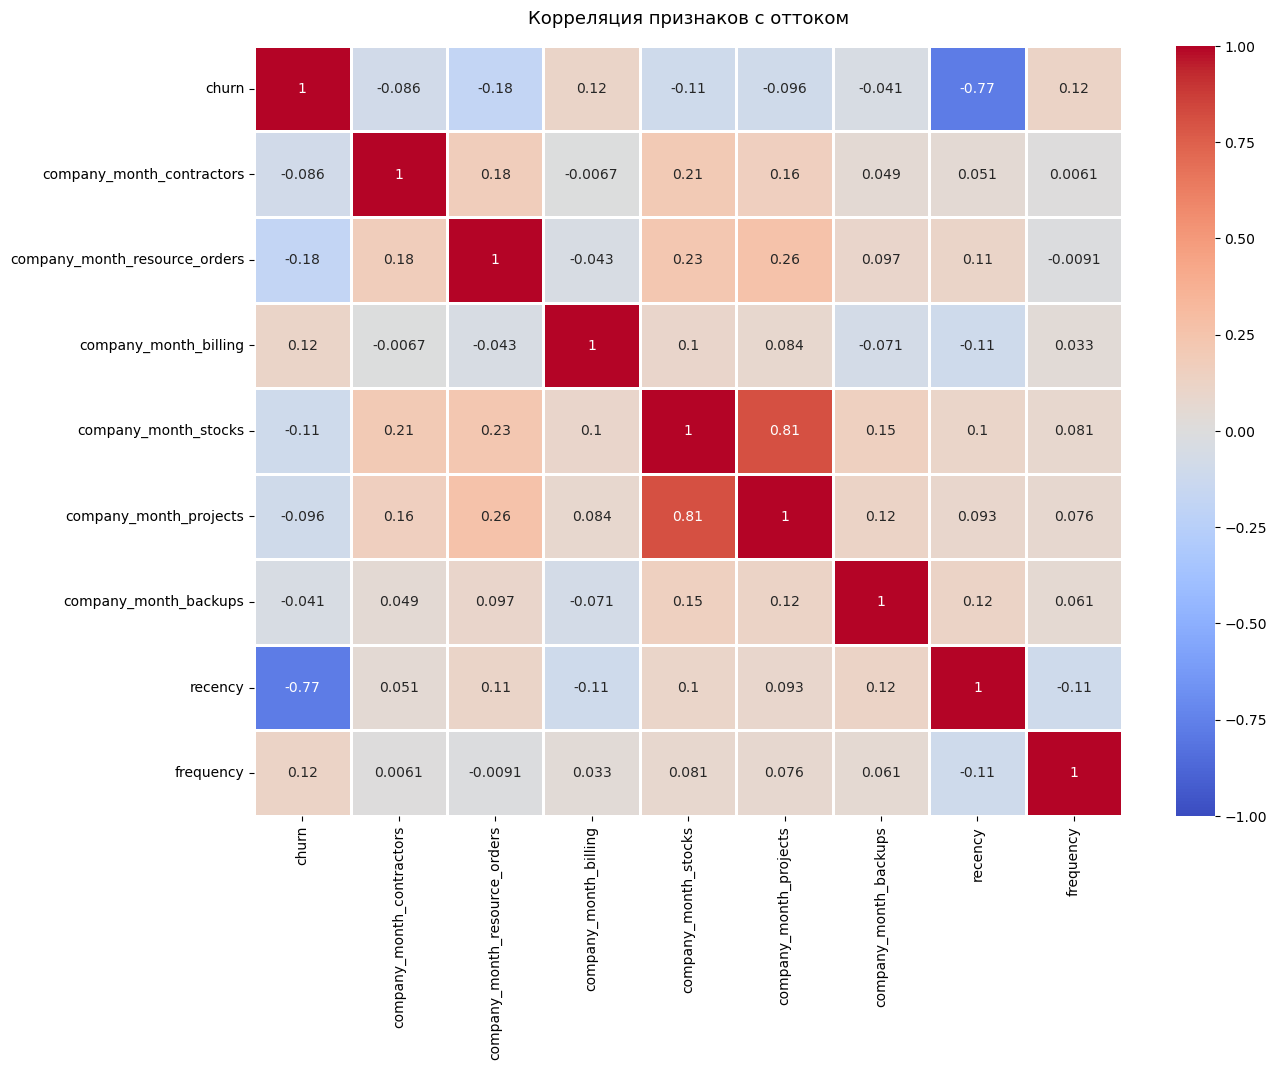

In [111]:
plt.figure(figsize=(14,10))

heatmap = sns.heatmap (df_corr.corr(), annot= True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1)
heatmap.set_title('Корреляция признаков c оттоком', fontdict={'fontsize':13}, pad=16);

Наибольшая корреляция с оттоком клиентов наблюдается у параметров:
- Количество заказов материалов компании за месяц `company_month_resource_orders`
- Количество счетов, выставленных в приложении, компанией за месяц `company_month_billing`
- Количество складов (аренда, заказы и т.д.), используемых компанией за месяц `company_month_stocks`
- Частота оплат `frequency`

Отрисуем матрицу корреляций для качественных признаков.

In [112]:
#присоединим данные из billing к датасету companies

companies_merged = companies.merge(billing[['churn','billing_tariff_price_id','company_id']],  how='left', on='company_id')

In [113]:
cols_to_keep1 = ["employer_count_interval", "billing_tariff_id", "billing_tariff_price_id", "churn"]
               
df_corr1  = companies_merged[cols_to_keep1]
df_corr1.head()

,employer_count_interval,billing_tariff_id,billing_tariff_price_id,churn
0,1,4.00,13.00,1.00
1,2,7.00,23.00,1.00
2,1,2.00,6.00,0.00
3,1,2.00,1.00,0.00
4,1,2.00,7.00,0.00


In [114]:
phik_overview = df_corr1.phik_matrix()

interval columns not set, guessing: ['employer_count_interval', 'billing_tariff_id', 'billing_tariff_price_id', 'churn']


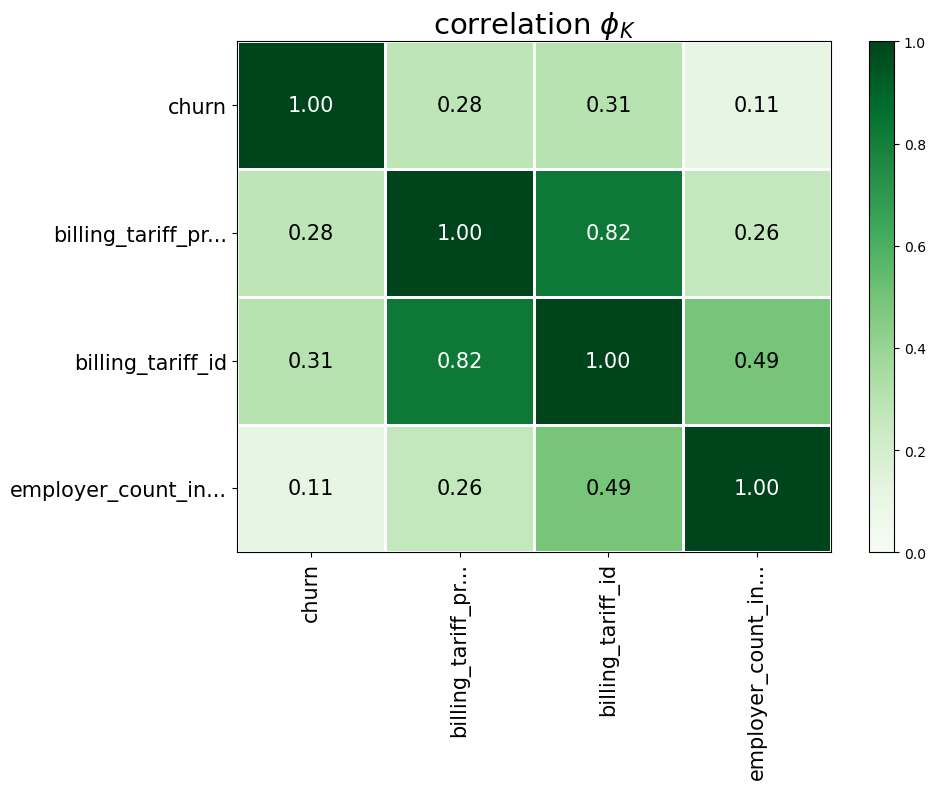

In [115]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Корреляция с целевой переменной оттока наблюдается с тарифным планом клиентов `billing_tariff_id` и с id стоимости тарифа `billing_tariff_price_id`

### Анализ клиентов в оттоке

In [116]:
billing['recency'].value_counts(),billing['frequency'].value_counts(),billing['tariff'].value_counts()

(recency
 60.00       61
 458.00      40
 449.00      31
 392.00      30
 1255.00     28
             ..
 -1232.00     1
 -601.00      1
 -75.00       1
 -327.00      1
 396.00       1
 Name: count, Length: 633, dtype: int64,
 frequency
 1.00     1160
 2.00      348
 3.00      172
 7.00       56
 6.00       51
 4.00       48
 8.00       46
 10.00      20
 5.00       19
 9.00       17
 Name: count, dtype: int64,
 tariff
 Base        868
 Start       812
 Business    141
 Profi       104
 Archive      12
 Name: count, dtype: int64)

Чтобы добиться более равномерного распределения сегментов, воспользуемся методом квантильного разделения данных.

Распределим на 3 группы по recency, где 
- 1 - это низкий показатель, клиенты были очень давно
- 2 - это средний показатель, клиенты были не так давно
- 3 - это хороший показатель, клиенты были совсем недавно.

In [117]:
billing['r_qcut'] = pd.qcut(billing['recency'], q=3, labels=['1', '2', '3'])

In [118]:
billing['r_qcut'].value_counts()

r_qcut
1    650
3    644
2    643
Name: count, dtype: int64

Выборка распределена приблизительно равномерно. В сегменте №1 количество клиентов достигает 650.

В предоттоке находится 643 клиента.

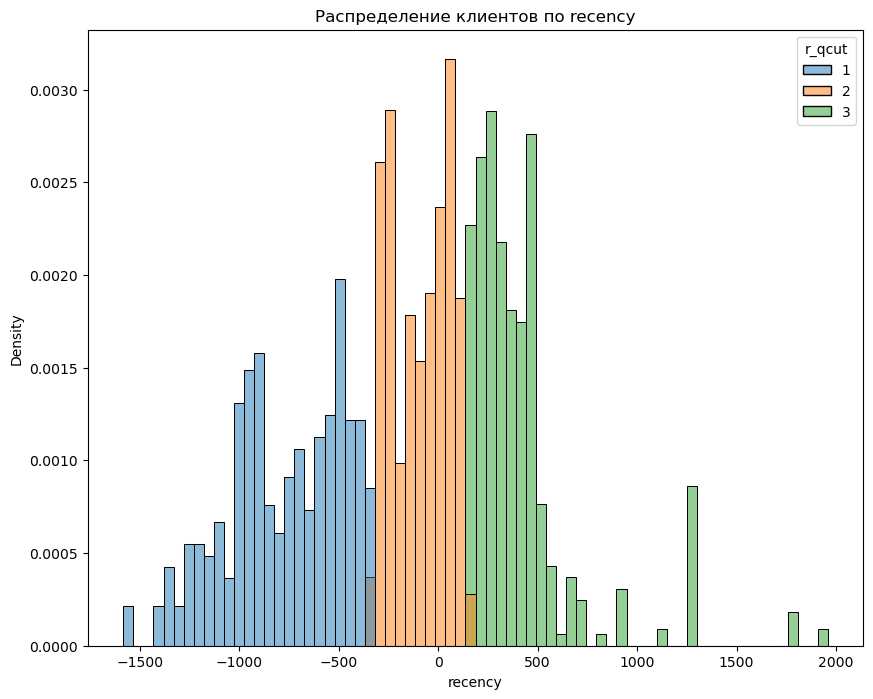

In [119]:
for column in ['recency']:
    plt.figure(figsize=(10,8))
    sns.histplot(data=billing, x=column, bins=70, hue="r_qcut", stat="density", common_norm=False)
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

Исходя из графика, клиенты распределились так:
- 1. Клиенты с длительностью непродления подписки от -350 дней до - 1500.
- 2. Клиенты с длительностью непродления подписки от -350 дней до 150 дней.
- 3. Клиенты с длительностью продления подписки от 150 дней и выше. Считаются лояльными клиентами.

In [120]:
lost_clients = billing[billing['r_qcut'] == '1']

In [121]:
lost_clients[lost_clients['churn'] == 0]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,last_date_pay,recency,churn,frequency,tariff,r_qcut


Клиентов с активной подпиской на приложение в данном сегменте нет.

In [122]:
lost_clients['company_id'].nunique()

334

In [123]:
lost_clients['company_id'].duplicated().sum()

316

In [124]:
lost_clients1 = lost_clients['company_id'].unique().tolist()

In [125]:
lost_clients1 = pd.DataFrame(lost_clients1)

In [126]:
lost_clients1.rename(columns = {0:'company_id'}, inplace = True)

In [127]:
lost_clients1

,company_id
0,2474
1,2035
2,2014
3,2353
4,366
...,...
329,7159
330,4879
331,7302
332,6071


Присоединим данные по companies, а именно количество сотрудников и тарифные планы.

In [128]:
lost_clients2 = lost_clients1.merge(companies[['employer_count_interval','created_at','billing_tariff_id','company_id']],  how='left', on='company_id')

In [129]:
lost_clients2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   company_id               334 non-null    int64         
 1   employer_count_interval  302 non-null    float64       
 2   created_at               302 non-null    datetime64[ns]
 3   billing_tariff_id        302 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 10.6 KB


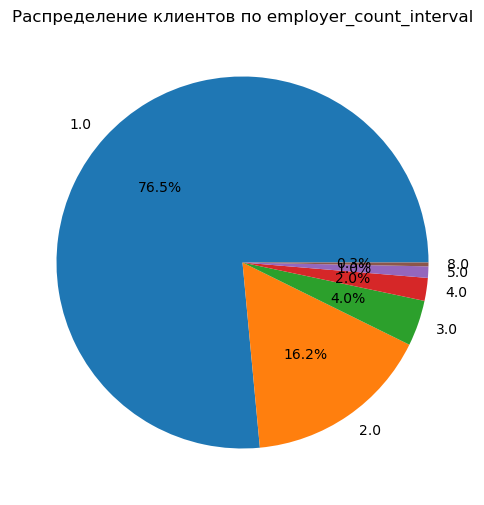

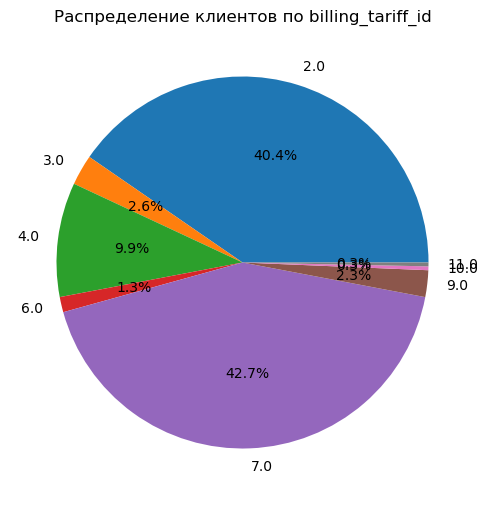

In [130]:
for column in ['employer_count_interval', 'billing_tariff_id']:
    data = lost_clients2 .groupby(column).agg({'company_id': 'count'})
    fig1, ax1 = plt.subplots(figsize=(6,8))
    ax1.pie(data['company_id'], labels=data.index, autopct='%1.1f%%')
    ax1.set_title(f'Распределение клиентов по {column}')
    plt.show()

Для клиентов, ушедших в отток, характерно:
- 77% компаний имеют до 4-х сотрудников, 16% имеют от 5-10 сотрудников. Иными словами, компании являются маленькими.
- 43% компаний до оттока использовали Стартовый тариф, 40% - тариф Базовый. 

Проверим, в какие годы были созданы аккаунты оттоковых клиентов.

In [131]:
lost_clients2['year_created'] = lost_clients2["created_at"].dt.to_period("Y")

In [132]:
lost1 = lost_clients2.pivot_table(index = 'year_created', values = 'company_id', aggfunc = ['count'])
lost1.reset_index(inplace= True )

In [133]:
lost1.columns = lost1.columns.droplevel(level=1)

In [134]:
lost1.head()

,year_created,count
0,2019,26
1,2020,119
2,2021,128
3,2022,26
4,2023,3


<Axes: xlabel='year_created', ylabel='count'>

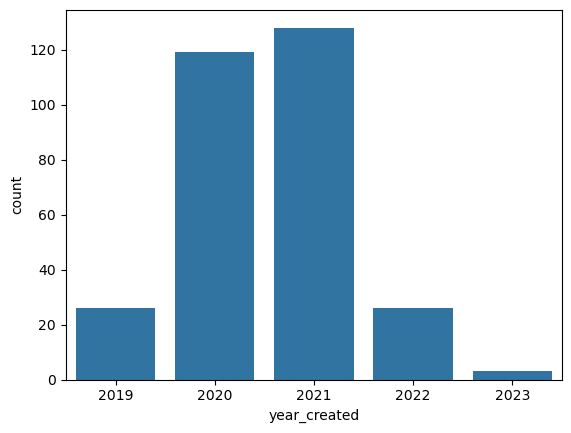

In [135]:
sns.barplot(data=lost1,x="year_created", y="count")

Большинство компаний из сегмента пришли в 2020-2021 г. Меньше всего оттоковых компаний пришло в 2023 г.

Присоединим данные из activities, но поскольку данные содержат дубли по `company_id`, то посмотрим только медиану и средние данные по сегменту.

In [136]:
#присоединим датасет activities

lost_clients2 = lost_clients2.merge(activities[['company_month_billing','company_month_stocks', 'company_month_backups','company_month_projects', 'company_month_contractors', 'company_month_resource_orders', 'company_id']],  how='left', on='company_id')

In [137]:
lost_clients2['company_id'].duplicated().sum()

1655

In [138]:
lost_clients2.describe().T

,count,mean,min,25%,50%,75%,max,std
company_id,1989.00,2500.22,1.00,1177.00,2565.00,3448.00,7302.00,1527.81
employer_count_interval,1957.00,1.39,1.00,1.00,1.00,2.00,8.00,0.78
created_at,1957,2020-11-16 14:04:36.158405632,2019-01-23 14:00:51,2020-05-29 00:01:47,2020-12-27 14:23:51,2021-05-26 13:42:25,2023-02-03 13:56:53,NaN
billing_tariff_id,1957.00,4.69,2.00,2.00,4.00,7.00,11.00,2.43
company_month_billing,1957.00,0.46,0.00,0.00,0.00,1.00,13.00,0.85
company_month_stocks,1957.00,5.33,0.00,0.00,2.00,6.00,166.00,11.01
company_month_backups,1957.00,1.03,0.00,0.00,0.00,0.00,13.00,2.83
company_month_projects,1957.00,5.20,0.00,1.00,2.00,5.00,166.00,10.51
company_month_contractors,1957.00,5.33,0.00,0.00,2.00,5.00,320.00,13.69
company_month_resource_orders,1957.00,4.93,0.00,0.00,0.00,0.00,586.00,25.77


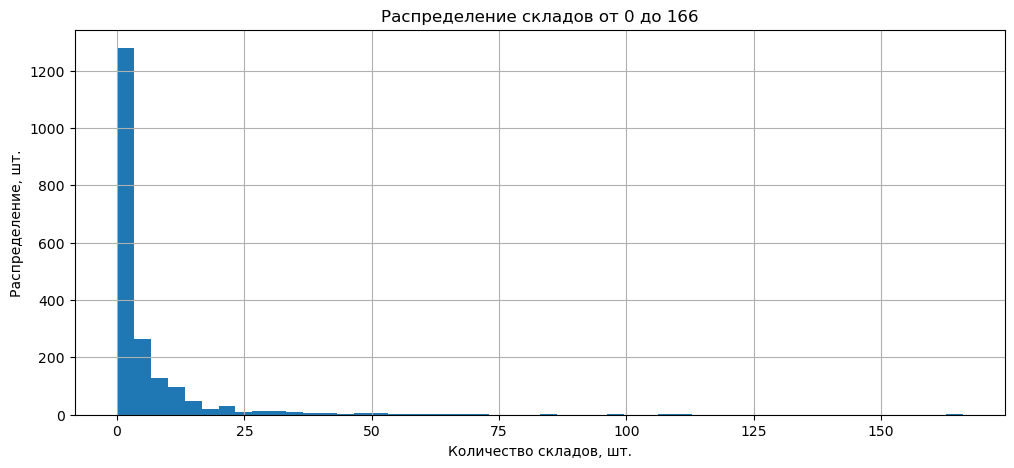

In [139]:
lost_clients2['company_month_stocks'].hist(figsize=(12,5), label='Количество складов', bins=50, range=(0,166))
plt.xlabel('Количество складов, шт.')
plt.ylabel('Распределение, шт.')
plt.title('Распределение складов от 0 до 166');

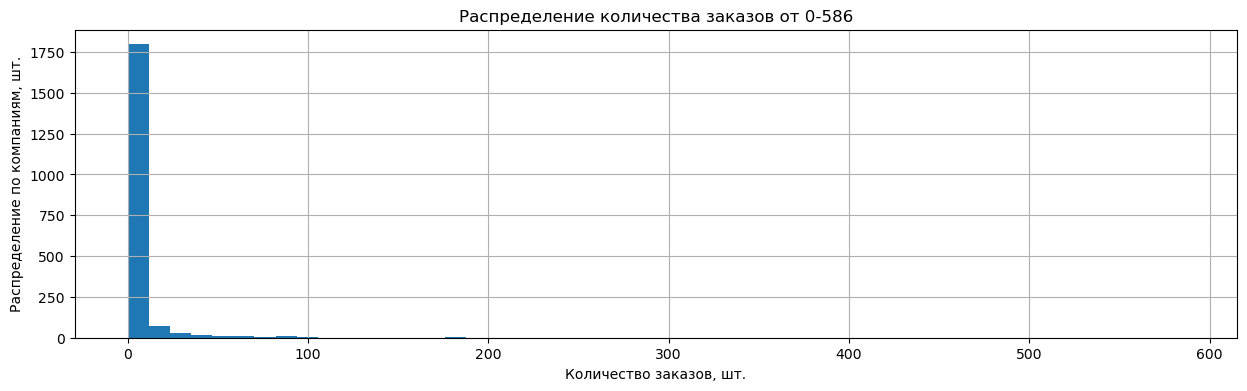

In [140]:
lost_clients2['company_month_resource_orders'].hist(figsize=(15,4), label='Количество заказов материалов', bins=50, range=(0,586))
plt.xlabel('Количество заказов, шт.')
plt.ylabel('Распределение по компаниям, шт.')
plt.title('Распределение количества заказов от 0-586');

Для клиентов, ушедших в отток, характерно:
- Использовать небольшое количество складов, до 2 штук.
- Не делать бэкап в приложении. Возможно, это обсуловлено ограничениями по тарифу, например, в Стартовом тарифе нет функции для бэкапа.
- Вести до 2-х проектов в месяц.
- Иметь около 2-х контрагентов.
- Заказывать мало материалов, до 5 заказов в среднем, тогда как медиана равна 0. То есть большая часть клиентов совсем не заказывали материалы, либо не вносили их в систему.

In [141]:
lost_clients2['year_created'] = lost_clients2['year_created'].astype(str)
lost_clients2['year_created'] = pd.to_datetime(lost_clients2['year_created'])
lost_clients2.dtypes

company_id                                int64
employer_count_interval                 float64
created_at                       datetime64[ns]
billing_tariff_id                       float64
year_created                     datetime64[ns]
company_month_billing                   float64
company_month_stocks                    float64
company_month_backups                   float64
company_month_projects                  float64
company_month_contractors               float64
company_month_resource_orders           float64
dtype: object

In [142]:
lost_clients2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   company_id                     1989 non-null   int64         
 1   employer_count_interval        1957 non-null   float64       
 2   created_at                     1957 non-null   datetime64[ns]
 3   billing_tariff_id              1957 non-null   float64       
 4   year_created                   1957 non-null   datetime64[ns]
 5   company_month_billing          1957 non-null   float64       
 6   company_month_stocks           1957 non-null   float64       
 7   company_month_backups          1957 non-null   float64       
 8   company_month_projects         1957 non-null   float64       
 9   company_month_contractors      1957 non-null   float64       
 10  company_month_resource_orders  1957 non-null   float64       
dtypes: datetime64[ns]

Посмотрим на распределение клиентов по продолжительности их жизни в приложении.

In [143]:
lost_clients2 = lost_clients2.merge(billing[['last_date_pay', 'company_id', 'tariff']],  how='left', on='company_id')

In [144]:
lost_clients2['lifetime'] = (lost_clients2['last_date_pay'] - lost_clients2['created_at']) / np.timedelta64 ( 1 , 'D')

In [145]:
lost_clients2.duplicated().sum()

3265

In [146]:
lost_clients2 = lost_clients2.drop_duplicates().reset_index(drop=True)

C:\Users\Ксюша\AppData\Local\Temp\ipykernel_7312\3079507624.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lost_clients2[column], hist=True,  bins=70, color = 'blue',  hist_kws={'edgecolor':'black'})


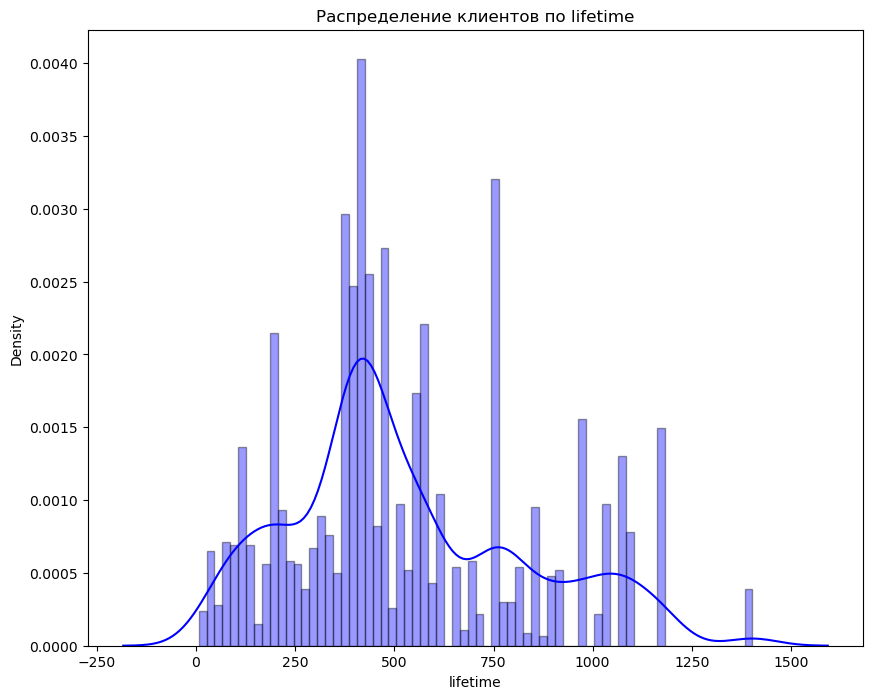

In [147]:
for column in ['lifetime']:
    plt.figure(figsize=(10,8))
    sns.distplot(lost_clients2[column], hist=True,  bins=70, color = 'blue',  hist_kws={'edgecolor':'black'})
    plt.title(f'Распределение клиентов по {column}')
    plt.show()

Большая часть клиентов живут до 500 дней в приложении, то есть 1,5 года.

Можно разбить клиентов на сегменты в зависимости от распределения по графику, например, до 250 дней, 250-500 дней, 500 - 800 и свыше 800 дней.

Посмотрим продолжительность клиентов в зависимости от тарифов.

In [148]:
#создаем функцию

def lifetime_category(life):
    if 0 <= life <= 250:
        return 'Short'
    if 250 < life <= 500:
        return 'Middle'
    if 500 < life <= 800:
        return 'Long'
    if 800 < life <= 2000:
        return 'Very long' 

In [149]:
# применим функцию и добавим новый столбец

lost_clients2['life_cat'] = lost_clients2['lifetime'].apply(lifetime_category)

In [150]:
life_churn = pd.crosstab(lost_clients2['life_cat'], df['tariff'])
life_churn

tariff,Archive,Base,Business,Profi,Start
life_cat,,,,,
Long,8,137,11,81,299
Middle,1,330,18,109,438
Short,1,153,2,24,235
Very long,2,114,12,8,266


- Во всех тарифах большинство компаний находились от 250 до 500 дней.

### Выводы

Общий портрет клиентов приложения Gectaro:

- Около 86% клиентов пользуются тарифами "Базовый" и "Стартовый".
- 80,7% компаний имею в штате до 10 сотрудников. 58% - имеют до 4 сотрудников в штате. 
- Более половины компаний оплачивали подписку 3 раза.
- Отток в компании составляет примерно 53%.

Наиболее важные параметры, оказывающие влияние на отток:


- тарифный план клиентов `billing_tariff_id` и id стоимости тарифа `billing_tariff_price_id` 
- количество заказов материалов `company_month_resource_orders` 
- количество счетов, выставленных в приложении, компанией за месяц `company_month_billing`
- количество складов (аренда, заказы и т.д.), используемых компанией `company_month_stocks`

Портрет клиентов, ушедших в отток:
- 77% компаний имеют до 4-х сотрудников, 16% имеют от 5-10 сотрудников. Иными словами, компании являются малым бизнесом.
- 43% компаний до оттока использовали Стартовый тариф, 40% - тариф "Базовый".
- Большинство компаний из сегмента пришли в 2020-2021 г. Меньше всего оттоковых компаний пришло в 2023 г.
- Используют небольшое количество складов, до 2 штук.
- Не делают бэкап в приложении. Возможно, это обсуловлено ограничениями по тарифу, например, в Стартовом тарифе нет функции для бэкапа.
- Ведут до 2-х проектов в месяц.
- Имеют около 2-х контрагентов.
- Заказывают мало материалов, до 5 заказов в среднем, тогда как медиана равна 0. То есть большая часть клиентов совсем не заказывали материалы, либо не вносили их в систему.
- Большая часть клиентов живут до 500 дней в приложении, то есть 1,5 года.

## Проверка гипотез

### Гипотеза №1. Среднее количество заказов материалов, выставленных в приложении, у групп оставшихся и отточных клиентов различаются.

**H0:** среднее количество заказов материалов у оставшихся и отточных клиентов равны

**H1:** среднее количество заказов материалов у оставшихся и отточных клиентов не равны

In [151]:
resource_churn = df[df['churn']==1]['company_month_resource_orders']
resource_nochurn = df[df['churn']==0]['company_month_resource_orders']

In [152]:
'Количество отточных клиентов:',len(resource_churn)

('Количество отточных клиентов:', 10128)

In [153]:
'Количество оставшихся клиентов:',len(resource_nochurn)

('Количество оставшихся клиентов:', 8731)

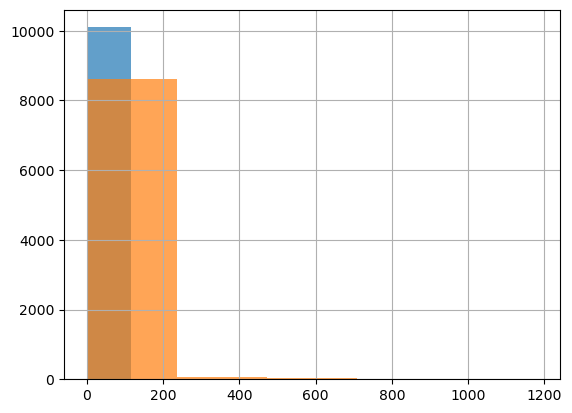

In [154]:
resource_churn.hist(bins = 5, alpha=0.7)
resource_nochurn.hist(bins = 5, alpha=0.7);

Выборки достаточно независимы друг от друга, но количество элементов в выборках сильно различается. 

Будем использовать тест Стьюдента, но с «правилом большого пальца»: если выборки разного размера — укажите equal_var = False при вызове метода scipy.stats.ttest_ind().

Альфа (уровень статистической значимости) - 0.05, что даст 95% вероятность правильности вывода. Если p-value окажется меньше него - отвергнем гипотезу.

In [155]:
results = st.ttest_ind (resource_churn, resource_nochurn, equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print (results.pvalue) 
# условный оператор с выводом строки с ответом

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

3.502884636778928e-120
Отвергаем нулевую гипотезу


Нулевая гипотеза об отсутствии различий в количестве закупаемых материалов должна быть отвергнута.

Значит, оттоковые и неоттоковые клиенты различаются по количеству закупаемых материалов.

### Выводы

В результате проверки гипотезы удалось выяснить:

- среднее количество заказов на материалы у оттоковых и удержанных клиентов различается.

## Выводы и рекомендации

Цель: выделить сегменты клиентов, склонных к оттоку, и сформулировать рекомендации по минимизации оттока в дальнейшем.

Выполненные задачи:
1. Загрузка и изучение данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Проверка статистических гипотез.
5. Выводы и рекомендации.

Общий портрет клиентов приложения Gectaro:

- Около 86% клиентов пользуются тарифами "Базовый" и "Стартовый".
- 80,7% компаний имею в штате до 10 сотрудников. 58% - имеют до 4 сотрудников в штате. 
- Более половины компаний оплачивали подписку 3 раза.
- Отток в компании составляет примерно 53%.

Наиболее важные параметры, оказывающие влияние на отток:

- тарифный план клиентов `billing_tariff_id` и id стоимости тарифа `billing_tariff_price_id` 
- количество заказов материалов `company_month_resource_orders` 
- количество счетов, выставленных в приложении, компанией за месяц `company_month_billing`
- количество складов (аренда, заказы и т.д.), используемых компанией `company_month_stocks`

Портрет клиентов, ушедших в отток:

- 77% компаний имеют до 4-х сотрудников, 16% имеют от 5-10 сотрудников. Иными словами, компании являются малым бизнесом.
- 43% компаний до оттока использовали Стартовый тариф, 40% - тариф "Базовый".
- Большинство компаний из сегмента пришли в 2020-2021 г. Меньше всего оттоковых компаний пришло в 2023 г.
- Используют небольшое количество складов, до 2 штук.
- Не делают бэкап в приложении. Возможно, это обсуловлено ограничениями по тарифу, например, в Стартовом тарифе нет функции для бэкапа.
- Ведут до 2-х проектов в месяц.
- Имеют около 2-х контрагентов.
- Заказывают мало материалов, до 5 заказов в среднем, тогда как медиана равна 0. То есть большая часть клиентов совсем не заказывали материалы, либо не вносили их в систему.
- Большая часть клиентов живут до 500 дней в приложении, то есть 1,5 года.

В результате проверки гипотез удалось выяснить:

- среднее количество заказов на материалы у оттоковых и удержанных клиентов различается.

Рекомендации по работе с оттоковым сегментом:
- У клиентов из оттокового сегмента слишком низкая активность в приложении. Они не заказывают материалы, ведут мало проектов и, скорее всего, им приложение становится менее полезным. Когда проектов не так много, компании могут и сами заниматься микро-менеджментом, поэтому оценивают свои трудозатраты дешевле, чем затраты на приложение. Возможно, этим компаниям, у которых пока немного объектов ведутся одновременно, важны другие данные, например, по тендерам на рынке, их стоимости.
- Мы бы рекомендовали опросить малый бизнес и узнать, каких функций в приложении им не хватает, поскольку на данный момент большинство функций позволяют автоматизировать процессы для крупных и средних строительств, а малым компаниям становится не выгодно, так как пользуются ими реже. Стоит разработать тариф, который бы содержал важный функционал на этапе, когда компания еще маленькая и только набирает клиентов.
- Возможно, у таких компаний большой уровень простоя, пока компании не выиграют новый тендер или не появятся новые заказы, поэтому помесячное оформление подписки может быть не так выгодно.